# Scientific Novelty and Impact Analysis

## Understanding the Relationship Between Research Novelty and Citation Impact

This notebook presents the **main analysis** for our study investigating how the **novelty** of scientific papers relates to their **citation impact** across three major research domains: **Artificial Intelligence (AI)**, **Physics**, and **Psychology**.

---

### Research Questions

We address the following fundamental questions about scientific discovery:

1. **Does novelty predict citation impact?** — Is there a systematic relationship between how novel a paper is and how many citations it receives?

2. **Is the novelty-impact relationship linear or non-linear?** — Do we observe an "inverted-U" pattern where moderate novelty is optimal, or does higher novelty always lead to more citations?

3. **Do these patterns vary across scientific fields?** — Are there discipline-specific dynamics in how the scientific community rewards novel work?


---

###  Methodology Overview

Our analysis pipeline includes:

| Step | Description |
|------|-------------|
| **Data Collection** | ~2.5M papers from Semantic Scholar (2005-2023) across AI, Physics, and Psychology |
| **Embedding Generation** | SPECTER2 768-dimensional dense embeddings for each paper |
| **Novelty Computation** | ANN-based novelty metric using cosine distance to k-nearest temporal neighbors |
| **Statistical Analysis** | Correlation analysis, binned statistics, and bootstrapped confidence intervals |

---

###  Notebook Structure

| Section | Description |
|---------|-------------|
| **1. Setup & Data Loading** | Environment configuration, data download, and preprocessing |
| **2. Exploratory Visualization** | Scatter plots and temporal trends |
| **3. Field-Specific Analysis** | Comparative analysis across AI, Physics, and Psychology |
| **4. Binned Statistical Analysis** | Robust analysis using quantile and fixed-width binning |
| **5. Case Studies** | Deep-dive into specific landmark papers and their neighborhoods |

---


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import duckdb
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from huggingface_hub import snapshot_download
# tueplots for publication-quality figures
from tueplots import bundles
from tueplots.constants.color import rgb  
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import matplotlib.colors as mcolors
import re
import textwrap
from matplotlib.lines import Line2D
from scipy import stats as scipy_stats



# Define colors for easy access
TUE_COLORS = {
    'blue': rgb.tue_blue,
    'red': rgb.tue_red,
    'gold': rgb.tue_gold,
    'dark': rgb.tue_dark,
    'gray': rgb.tue_gray,
}

# Field colors using palette
FIELD_COLORS = {
    'AI': rgb.tue_red,
    'Physics': rgb.tue_blue,
    'Psychology': rgb.tue_gold,
    'Other': rgb.tue_gray
}

# Set global tueplots style for ICML 2024
plt.rcParams.update(bundles.icml2024(column="full", nrows=1, ncols=2))

### Download Pre-computed Data

Our dataset is hosted on **Hugging Face Hub** ([lalit3c/S2_CS_PHY_PYSCH_papers](https://huggingface.co/datasets/lalit3c/S2_CS_PHY_PYSCH_papers)) for reproducibility. The following files are downloaded:

| File | Description | Size |
|------|-------------|------|
| `S2_papers_cleaned.db` | Primary paper metadata (title, citations, field labels, topics) | ~4.3GB |
| `S2_papers_cleaned_additional_papers.db` | Supplementary papers from extended collection | ~283MB |
| `metrics.db` | Pre-computed novelty metrics (mean, std, neighbors) | ~60MB |

The download is **incremental** — files already present in `./data/` are skipped.

In [2]:
os.makedirs("data", exist_ok=True)
files_to_download = [
    "S2_papers_cleaned.db",
    "S2_papers_cleaned_additional_papers.db",
    "metrics.db"
]
for file_name in files_to_download:
    if not os.path.exists(os.path.join("data", file_name)):
        snapshot_download(
            repo_id="lalit3c/S2_CS_PHY_PYSCH_papers",
            repo_type="dataset",
            local_dir="data",
            local_dir_use_symlinks=False,
            allow_patterns=[file_name]
        )
    print(f"{file_name} already exists")

S2_papers_cleaned.db already exists
S2_papers_cleaned_additional_papers.db already exists
metrics.db already exists


### Configuration Constants

We define key configuration parameters that control the analysis:

- **`NOVELTY_COL`**: The novelty metric used (1 - mean of k-NN distances in embedding space)
- **`CITATION_COL`**: The impact metric (raw citation count from Semantic Scholar)

> **Note on Novelty Metric**: Our novelty score is computed as the 1 - mean cosine distance to the k-nearest neighbors published *before* each paper. Higher values indicate greater semantic distance from prior work — i.e., more novel content.

In [3]:
# Configuration
DB_DIR = 'data'
NOVELTY_COL = 'novelty_mean'
CITATION_COL = 'citation_count'

## 2. Data Loading and Preprocessing

### 2.1 Load and Merge Databases

We load data from multiple DuckDB databases and merge them into a unified analysis-ready DataFrame:

1. **Metrics database**: Contains pre-computed novelty scores and neighbor information
2. **Papers databases**: Contains metadata (title, citations, publication date, field labels)

The merge is performed on `corpus_id` to combine novelty metrics with paper metadata.

In [4]:
def load_databases():
    """Load data from DuckDB databases and merge into a single dataframe."""
    # Connect to databases
    metrics = duckdb.connect(f'{DB_DIR}/metrics.db')
    papers_1 = duckdb.connect(f'{DB_DIR}/S2_papers_cleaned.db')
    papers_2 = duckdb.connect(f'{DB_DIR}/S2_papers_cleaned_additional_papers.db')
    
    # Load dataframes
    metrics_df = metrics.execute("SELECT * FROM paper_neighbors").df()
    papers_1_df = papers_1.execute(
        "SELECT corpusid, title, citation_count, publication_date, is_physics, is_ai, is_psych, primary_topic FROM papers_with_abstracts"
    ).df()
    papers_2_df = papers_2.execute(
        "SELECT corpusid, title, citation_count, publication_date, is_physics, is_ai, is_psych, primary_topic FROM papers_with_abstracts"
    ).df()
    
    # Combine papers
    papers_df = pd.concat([papers_1_df, papers_2_df], ignore_index=True)
    
    # Type conversions
    metrics_df['corpus_id'] = metrics_df['corpus_id'].astype(int)
    papers_df['corpusid'] = papers_df['corpusid'].astype(int)
    
    # Merge all datasets
    merged_df = metrics_df.merge(
        papers_df, 
        left_on='corpus_id', 
        right_on='corpusid', 
        how='inner'
    )
    
    return merged_df

merged_df = load_databases()
print(f"Total papers: {len(merged_df):,}")
print(f"Physics: {merged_df['is_physics'].sum():,}")
print(f"AI: {merged_df['is_ai'].sum():,}")
print(f"Psychology: {merged_df['is_psych'].sum():,}")

Total papers: 2,563,401
Physics: 966,722
AI: 744,251
Psychology: 896,917


### 2.2 Data Filtering and Normalization

We apply the following preprocessing steps to ensure data quality:

**Temporal Filtering:**
- Include papers published between **2005 and 2023**
- This ensures sufficient citation accumulation time while capturing modern research trends

**Citation Filtering:**
- Exclude papers with **zero citations** to focus on papers that have had measurable impact
- Papers with no citations may represent preprints, errors, or very recent publications

**Novelty Normalization:**
- Normalize novelty scores to the **[0, 1]** range using min-max scaling
- This facilitates comparison across fields and intuitive interpretation

In [5]:
merged_df['publication_year'] = pd.to_datetime(merged_df['publication_date']).dt.year
merged_df.head()

corpus_id  cosine_similarity  novelty_mean  novelty_max  novelty_min  \
0      46377                NaN      0.188341     0.147239     0.199062   
1     156935                NaN      0.179116     0.129403     0.191965   
2     450770                NaN      0.113655     0.084610     0.126846   
3     480601                NaN      0.165810     0.111058     0.184220   
4     498070                NaN      0.161560     0.127612     0.171923   

   novelty_median  novelty_harmonic  corpusid  \
0        0.192427          0.187644     46377   
1        0.183315          0.178051    156935   
2        0.115920          0.112768    450770   
3        0.170726          0.163764    480601   
4        0.164782          0.160970    498070   

                                               title  citation_count  \
0  Voltage Dependence of Slow Inactivation in Sha...              18   
1  Rhythmical eye-head-torso rotation alters fore...               4   
2                   The ages of quasar host galaxies              84   
3  Minimizing Binding Errors Using Learned Conjun...              63   
4  Application of GRID to Foreign Atom Localizati...               0   

  publication_date  is_physics  is_ai  is_psych  \
0       2000-02-01       False  False      True   
1       2000-02-01       False  False      True   
2       2000-02-01        True  False     False   
3       2000-02-01       False   True     False   
4       2000-02-01        True  False     False   

                                   primary_topic  publication_year  
0            Ion channel regulation and function              2000  
1          Hemispheric Asymmetry in Neuroscience              2000  
2      Galaxies: Formation, Evolution, Phenomena              2000  
3  Advanced Image and Video Retrieval Techniques              2000  
4               Nuclear Physics and Applications              2000

In [6]:
# keep only papers between 2005 and 2023
merged_df = merged_df[
    (merged_df['publication_year'] >= 2005) & 
    (merged_df['publication_year'] <= 2023)
].copy()
print(f"Total papers: {len(merged_df):,}")
print(f"Physics: {merged_df['is_physics'].sum():,}")
print(f"AI: {merged_df['is_ai'].sum():,}")
print(f"Psychology: {merged_df['is_psych'].sum():,}")

Total papers: 2,124,049
Physics: 804,726
AI: 586,840
Psychology: 768,226


In [7]:
# drop rows with 0 citation
merged_df = merged_df[merged_df['citation_count'] > 0].copy()
print(f"Total papers: {len(merged_df):,}")
print(f"Physics: {merged_df['is_physics'].sum():,}")
print(f"AI: {merged_df['is_ai'].sum():,}")
print(f"Psychology: {merged_df['is_psych'].sum():,}")

# normalise novelty between 0 and 1
merged_df[NOVELTY_COL] = (merged_df[NOVELTY_COL] - merged_df[NOVELTY_COL].min()) / (merged_df[NOVELTY_COL].max() - merged_df[NOVELTY_COL].min())

Total papers: 1,871,096
Physics: 717,957
AI: 505,069
Psychology: 674,204


### 2.3 Field Classification

Papers are classified into three primary research domains based on OpenAlex topic matching:

| Field | Description | Typical Topics |
|-------|-------------|----------------|
| **AI** | Artificial Intelligence & Machine Learning | Deep learning, NLP, computer vision, robotics |
| **Physics** | Physical Sciences | Particle physics, condensed matter, astrophysics |
| **Psychology** | Behavioral & Cognitive Sciences | Cognitive psychology, social psychology, neuroscience |

> **Note**: Papers may belong to multiple fields. For this analysis, we use a hierarchical assignment where AI takes precedence over Physics, which takes precedence over Psychology.

In [8]:
# Add field column
def get_field(row):
    if row['is_ai']:
        return 'AI'
    elif row['is_physics']:
        return 'Physics'
    elif row['is_psych']:
        return 'Psychology'
    else:
        return 'Other'

merged_df['field'] = merged_df.apply(get_field, axis=1)

# Create field-specific dataframes
physics_df = merged_df[merged_df['is_physics'] == True]
ai_df = merged_df[merged_df['is_ai'] == True]
psych_df = merged_df[merged_df['is_psych'] == True]

---

## 3. Exploratory Visualization

### 3.1 Temporal Trends: Novelty vs Citations by Year

To understand how the novelty-citation relationship evolves over time, we visualize scatter plots for each publication year. This reveals:

- **Temporal consistency**: Is the relationship stable across decades?
- **Field maturation**: Do older vs newer papers show different patterns?
- **Citation accumulation**: How does the time-to-accrue-citations affect our observations?

Each subplot shows the Pearson correlation coefficient (r) to quantify the linear relationship strength.

In [ ]:
def plot_novelty_by_year(df, metric_col, metric_name, start_year=2000, end_year=2025):
    """Plot novelty vs metric by publication year in a grid."""
    # Filter data
    year_filtered = df[
        (df['publication_year'] >= start_year) & 
        (df['publication_year'] <= end_year)
    ].copy()
    
    years = sorted(year_filtered['publication_year'].unique())
    n_years = len(years)
    n_cols = 6
    n_rows = int(np.ceil(n_years / n_cols))
    
    fig = plt.figure(figsize=(24, 20))
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.4, wspace=0.3)
    
    for idx, year in enumerate(years):
        row = idx // n_cols
        col = idx % n_cols
        
        year_data = year_filtered[year_filtered['publication_year'] == year]
        plot_data = year_data 
        
        # Calculate correlation
        corr = year_data[NOVELTY_COL].corr(year_data[metric_col]) if len(year_data) > 10 else np.nan
        
        ax = fig.add_subplot(gs[row, col])
        ax.scatter(plot_data[NOVELTY_COL], plot_data[metric_col],
                  c='#2E86AB', alpha=0.4, s=4, edgecolors='none', rasterized=True)
        
        ax.set_xlabel('Novelty', fontsize=9)
        # ax.set_xlim(0, 0.22)
        ax.set_ylabel(metric_name, fontsize=9)
        ax.set_title(f'{int(year)} (n={len(year_data):,}, r={corr:.2f})', 
                     fontsize=10, fontweight='bold', pad=8)
        
        if 'count' in metric_col.lower():
            ax.set_yscale('log')
        
        ax.tick_params(labelsize=8)
        ax.grid(True, alpha=0.2, linestyle=':', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    fig.suptitle(f'Novelty vs {metric_name} by Year ({start_year}-{end_year})', 
                 fontsize=20, fontweight='bold', y=0.995)
    return fig

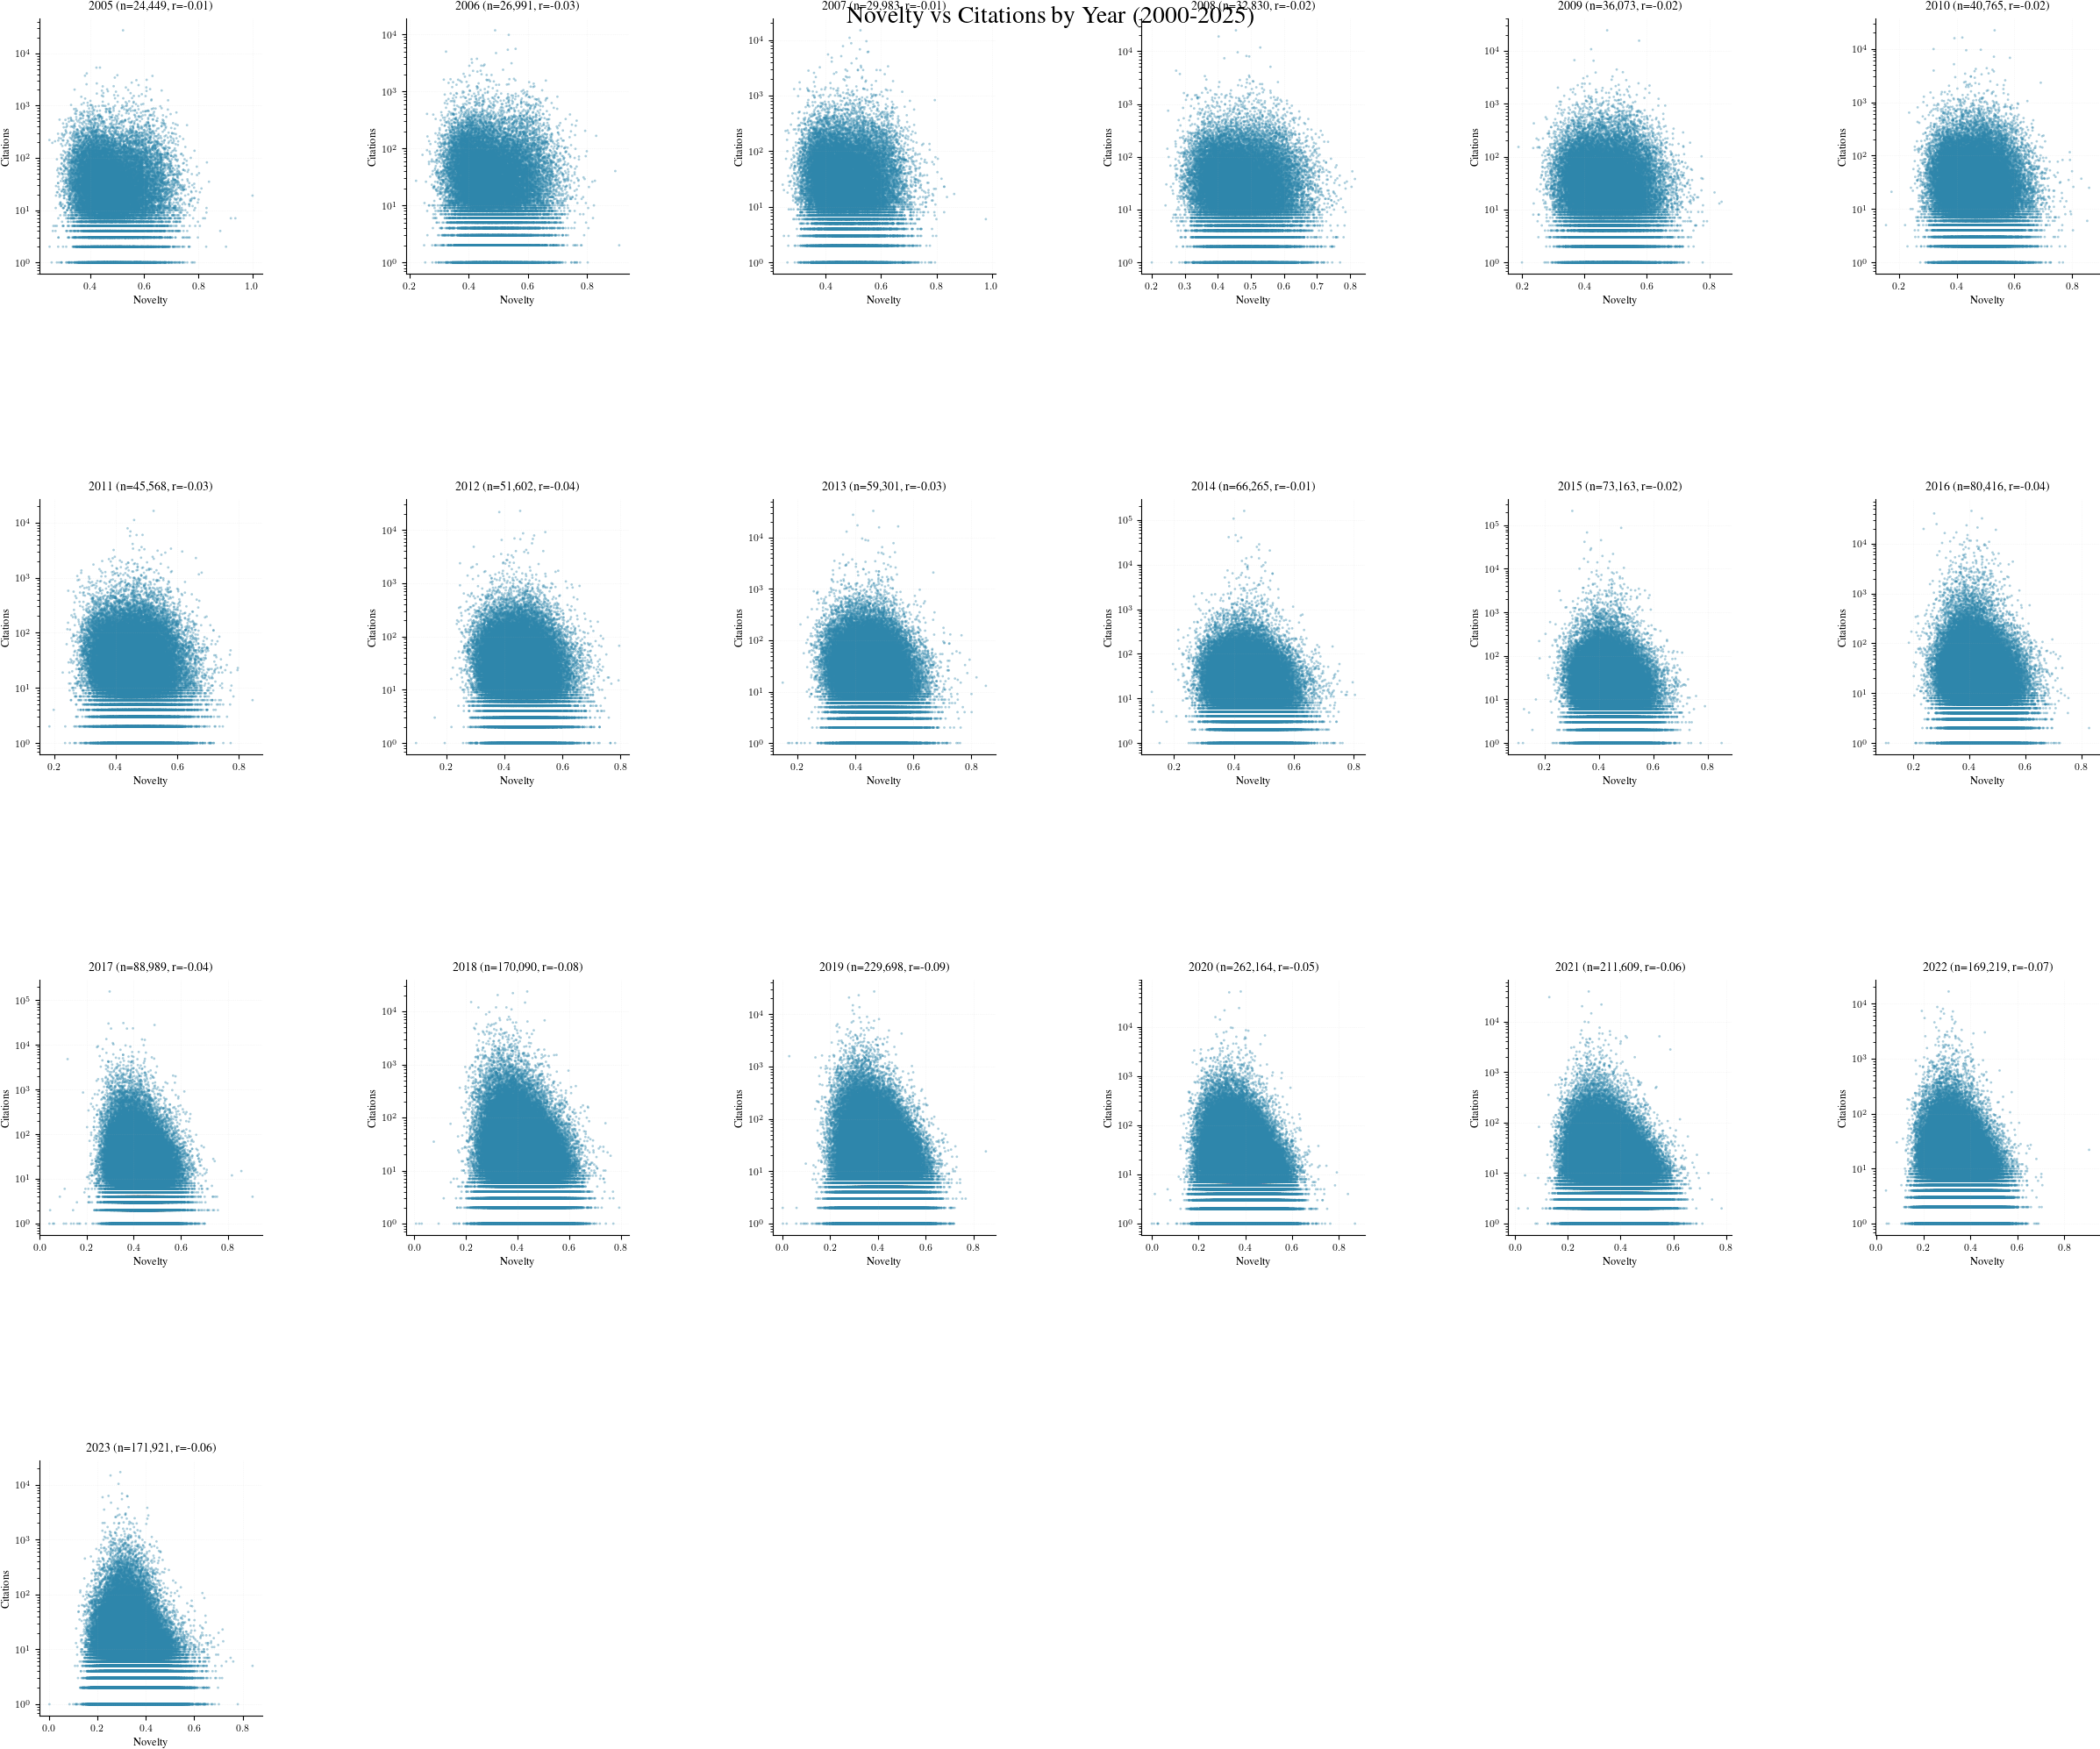

In [10]:
# Plot novelty vs citations by year
fig = plot_novelty_by_year(merged_df, CITATION_COL, 'Citations')
plt.show()

### 3.2 Field-Specific Patterns

Different scientific disciplines may reward novelty differently due to:

- **Paradigm structure**: Fields with strong paradigms (Physics) vs. pre-paradigmatic fields (Psychology)
- **Publication culture**: Conference-driven (AI) vs. journal-driven (Psychology) cultures
- **Citation practices**: Field-specific norms around citing prior work

This visualization compares the novelty-citation relationship across our three domains.

In [ ]:
def plot_novelty_by_field(df, metric_col, metric_name, start_year=2000, end_year=2025):
    """Plot novelty vs metric for each field."""
    year_filtered = df[
        (df['publication_year'] >= start_year) & 
        (df['publication_year'] <= end_year)
    ].copy()
    
    fields = ['Physics', 'AI', 'Psychology']
    colors = {'Physics': '#2E86AB', 'AI': '#A23B72', 'Psychology': '#F18F01'}
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, field in enumerate(fields):
        field_data = year_filtered[year_filtered['field'] == field]
        plot_data = field_data
        
        corr = field_data[NOVELTY_COL].corr(field_data[metric_col]) if len(field_data) > 10 else np.nan
        
        ax = axes[idx]
        ax.scatter(plot_data[NOVELTY_COL], plot_data[metric_col],
                  c=colors[field], alpha=0.7, s=2, edgecolors='none', rasterized=True)
        
        ax.set_xlabel('Novelty', fontsize=12)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_title(f'{field} (n={len(field_data):,}, r={corr:.2f})', 
                     fontsize=14, fontweight='bold', pad=10)
        
        if 'count' in metric_col.lower():
            ax.set_yscale('log')
        
        ax.tick_params(labelsize=10)
        ax.grid(True, alpha=0.4, linestyle=':', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    fig.suptitle(f'Novelty vs {metric_name} by Field ({start_year}-{end_year})', 
                 fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_49046/971080696.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


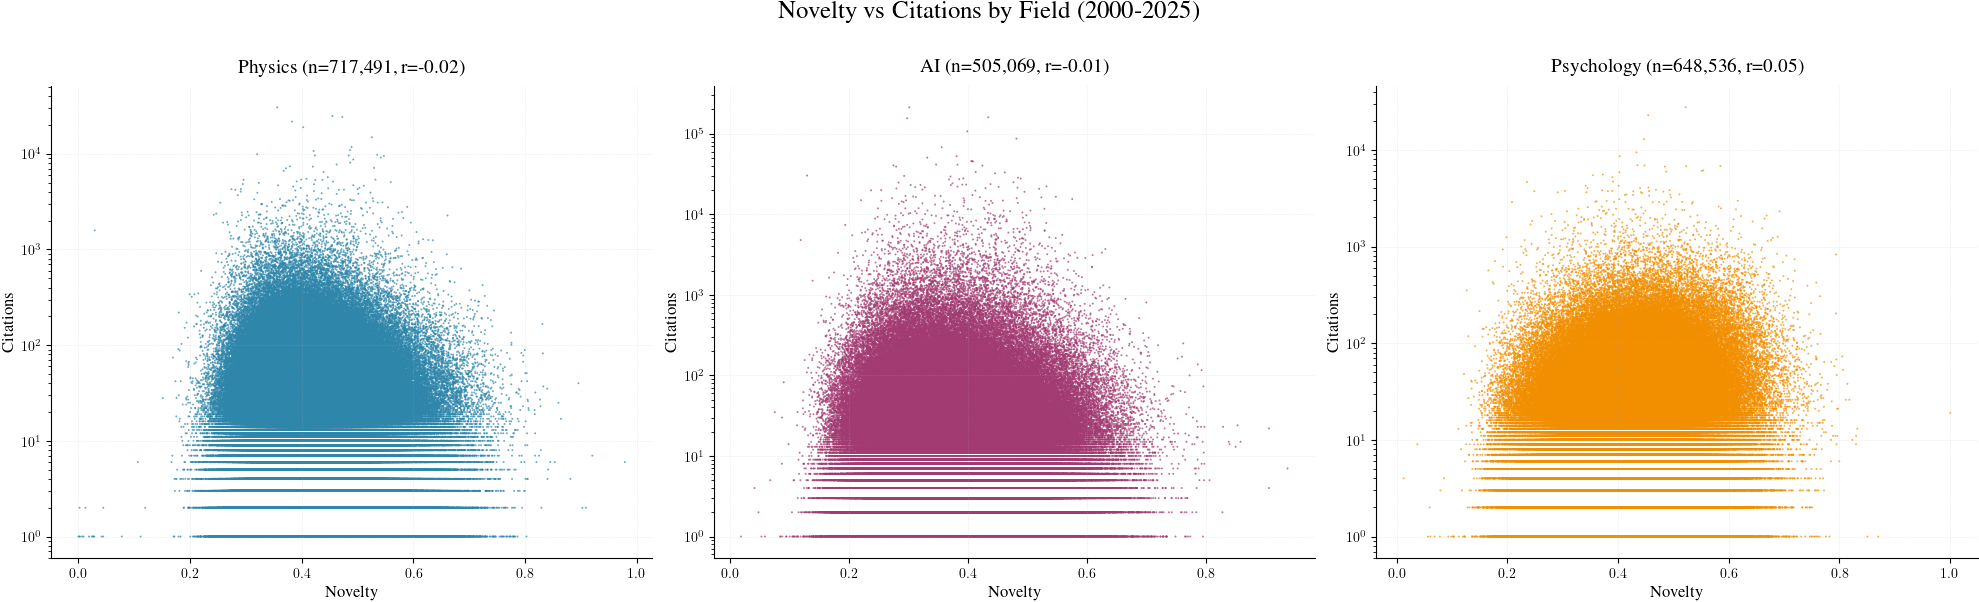

In [12]:
# Plot by field
fig = plot_novelty_by_field(merged_df, CITATION_COL, 'Citations')
plt.show()

---

## 4. Top Papers Analysis

### 4.1 Identifying Extreme Papers

To understand the characteristics of exceptional papers, we identify:

1. **Top 1000 Most Cited Papers** per field — representing high-impact work
2. **Top 1000 Most Novel Papers** per field — representing highly innovative work

This allows us to examine whether highly-cited papers tend to be highly novel, or whether these represent distinct populations.

In [13]:
def get_top_papers_by_metric(df, metric_col, n=1000):
    """Get top N papers by a given metric for each field."""
    results = {}
    for field in ['AI', 'Physics', 'Psychology']:
        field_data = df[df['field'] == field]
        top_papers = field_data.nlargest(n, metric_col)
        results[field] = top_papers
    return results

# Get top 1000 papers by citations
top_cited = get_top_papers_by_metric(merged_df, CITATION_COL, 1000)

# Get top 1000 papers by novelty
top_novel = get_top_papers_by_metric(merged_df, NOVELTY_COL, 1000)

### 4.2 Comparing Top Cited vs Top Novel Papers

This visualization compares the distribution of papers selected by different criteria:

**Top Row**: Papers selected for having the **highest citations** — where do they fall on the novelty spectrum?

**Bottom Row**: Papers selected for having the **highest novelty** — how many citations do they receive?

> **Key Question**: Is there overlap between these populations, or do highly-cited and highly-novel represent distinct paper types?

In [14]:
def plot_top_papers_comparison(top_cited_dict, top_novel_dict, metric_col=None):
    """Plot novelty vs citations for top papers by different criteria."""
    if metric_col is None:
        metric_col = CITATION_COL
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fields = ['AI', 'Physics', 'Psychology']
    
    # Calculate global limits
    all_novelty = np.concatenate([top_cited_dict[f][NOVELTY_COL].dropna().values for f in fields])
    x_min, x_max = all_novelty.min(), all_novelty.max()
    x_padding = (x_max - x_min) * 0.05
    
    # Top cited papers
    for idx, field in enumerate(fields):
        data = top_cited_dict[field]
        ax = axes[0, idx]
        sns.scatterplot(x=NOVELTY_COL, y=metric_col, data=data, ax=ax, alpha=0.6, s=40, edgecolor='none')
        ax.set_title(f'{field} - Top Cited', fontweight='bold', pad=10)
        ax.set_ylabel('Citation Count', fontweight='bold')
        ax.set_xlabel('Novelty', fontweight='bold')
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Top novel papers
    for idx, field in enumerate(fields):
        data = top_novel_dict[field]
        ax = axes[1, idx]
        sns.scatterplot(x=NOVELTY_COL, y=metric_col, data=data, ax=ax, alpha=0.6, s=40, edgecolor='none')
        ax.set_title(f'{field} - Top Novel', fontweight='bold', pad=10)
        ax.set_ylabel('Citation Count', fontweight='bold')
        ax.set_xlabel('Novelty', fontweight='bold')
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    fig.suptitle('Top 1000 Papers: Citation vs Novelty Comparison', fontsize=16, fontweight='bold', y=1.02)
    return fig

/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_46766/1540253405.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


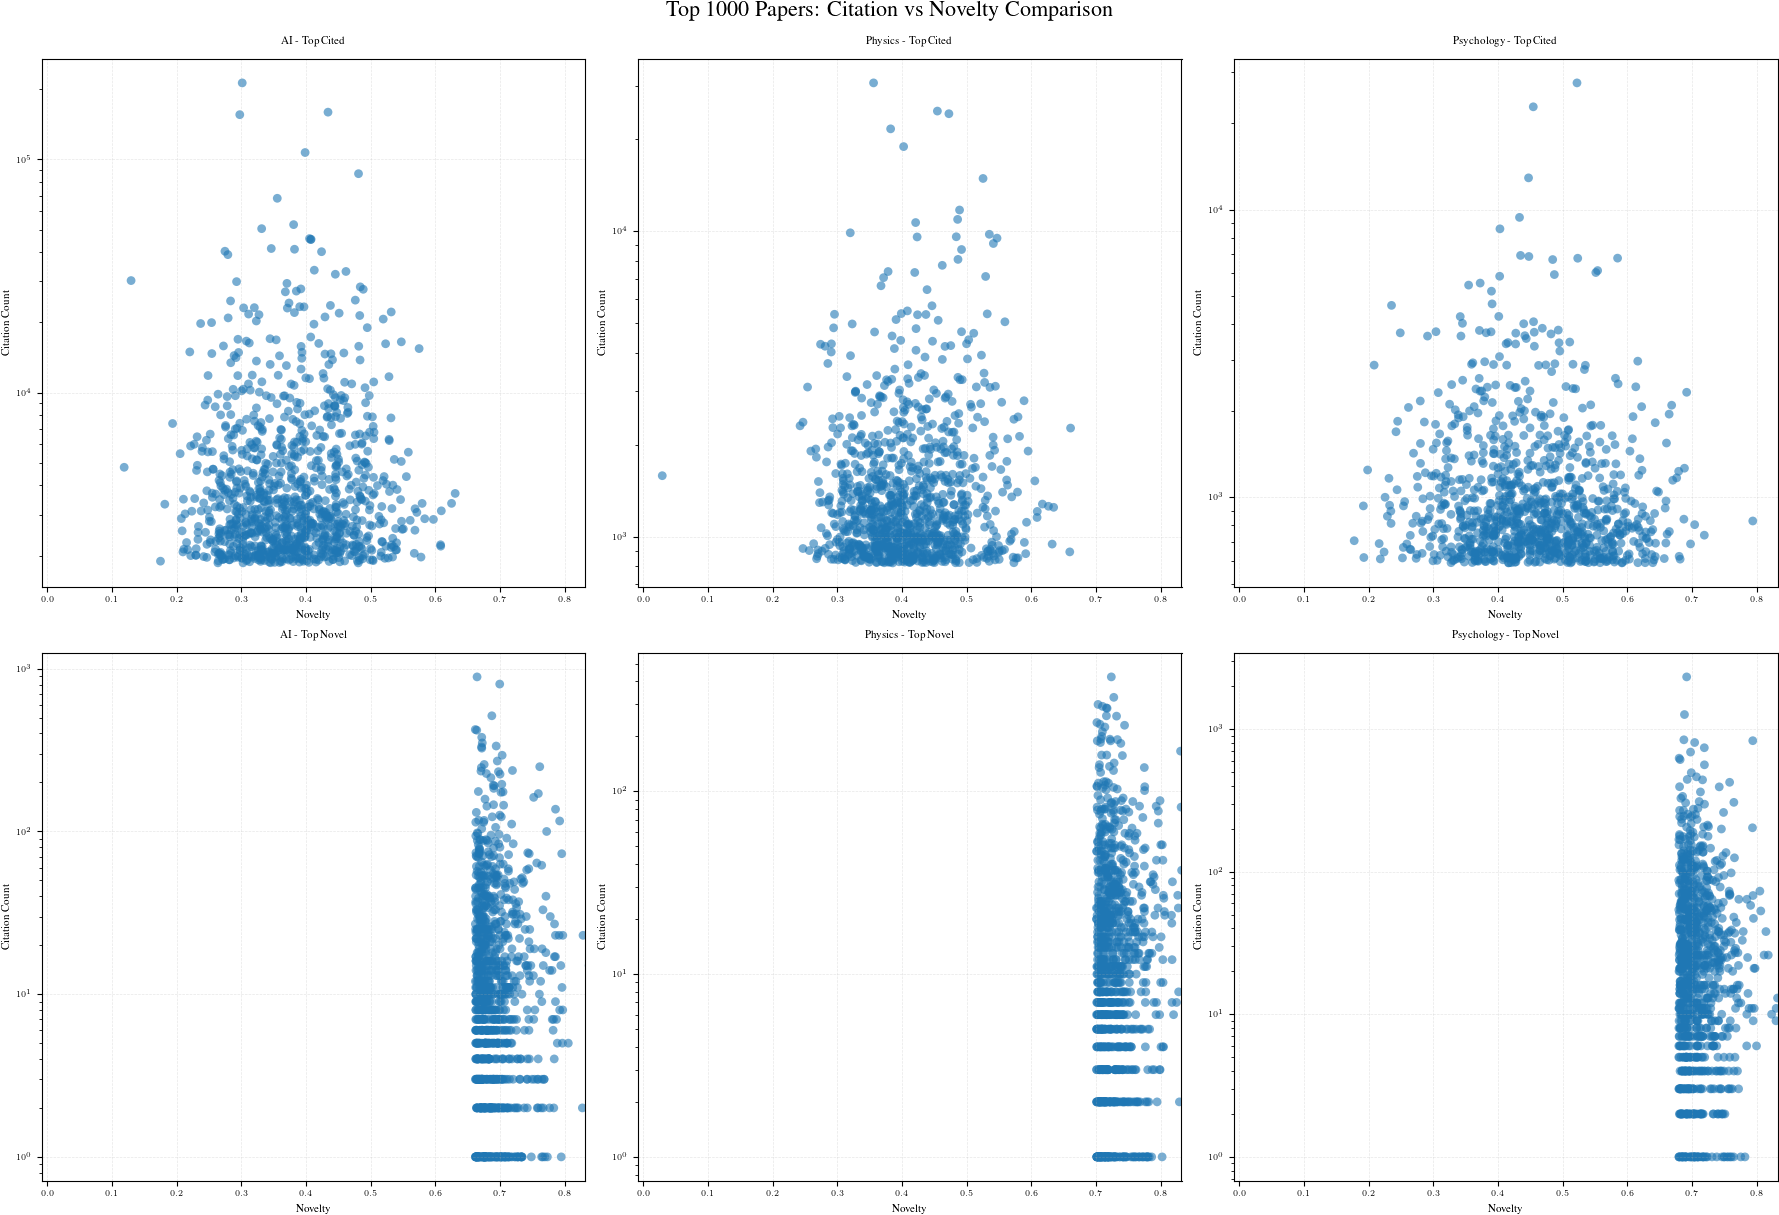

In [20]:
fig = plot_top_papers_comparison(top_cited, top_novel)
plt.show()

---

## 5. Binned Statistical Analysis

### 5.1 Quantile-Based Binning

Raw scatter plots can obscure systematic trends due to:
- **Heteroscedasticity**: Variance in citations increases with novelty
- **Outliers**: A few highly-cited papers can dominate visual interpretation
- **Density variation**: Most papers cluster at low novelty

**Binned analysis** addresses these issues by:
1. Dividing papers into equal-frequency bins based on novelty
2. Computing mean/median citations within each bin
3. Reporting standard errors to quantify uncertainty

This approach reveals the **central tendency** of the novelty-citation relationship.

In [15]:
def create_novelty_bins(df, n_bins=100):
    """Create novelty bins and calculate statistics."""
    df_clean = df[[NOVELTY_COL, CITATION_COL, 'field']].dropna().copy()
    
    # Overall bins
    df_clean['novelty_bin'] = pd.qcut(df_clean[NOVELTY_COL], q=n_bins, labels=False, duplicates='drop')
    
    # Overall statistics
    overall_stats = df_clean.groupby('novelty_bin').agg({
        CITATION_COL: ['mean', 'median', 'count'],
        NOVELTY_COL: 'mean'
    }).reset_index()
    overall_stats.columns = ['bin', 'citation_mean', 'citation_median', 'count', 'novelty_mean']
    
    # Per-field statistics
    field_stats = df_clean.groupby(['field', 'novelty_bin']).agg({
        CITATION_COL: ['mean', 'median', 'count'],
        NOVELTY_COL: 'mean'
    }).reset_index()
    field_stats.columns = ['field', 'bin', 'citation_mean', 'citation_median', 'count', 'novelty_mean']
    
    return overall_stats, field_stats

In [17]:
def plot_novelty_bins(overall_stats, field_stats):
    """Plot binned novelty analysis."""
    # Overall plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Mean citations
    ax0 = axes[0]
    ax0_twin = ax0.twinx()
    ax0.plot(overall_stats['novelty_mean'], overall_stats['citation_mean'], 
             linewidth=2, color='blue', label='Mean Citations')
    ax0_twin.bar(overall_stats['novelty_mean'], overall_stats['count'], 
                alpha=0.2, color='gray', width=0.002, label='Paper Count')
    ax0.set_xlabel('Novelty (Binned)', fontsize=12)
    ax0.set_ylabel('Mean Citations', fontsize=12, color='blue')
    ax0_twin.set_ylabel('Paper Count', fontsize=12, color='gray')
    ax0.set_title('Mean Citations vs Novelty Bins', fontsize=14, fontweight='bold')
    ax0.grid(True, alpha=0.3)
    
    # Median citations
    ax1 = axes[1]
    ax1_twin = ax1.twinx()
    ax1.plot(overall_stats['novelty_mean'], overall_stats['citation_median'], 
             linewidth=2, color='green', label='Median Citations')
    ax1_twin.bar(overall_stats['novelty_mean'], overall_stats['count'], 
                alpha=0.2, color='gray', width=0.002, label='Paper Count')
    ax1.set_xlabel('Novelty (Binned)', fontsize=12)
    ax1.set_ylabel('Median Citations', fontsize=12, color='green')
    ax1_twin.set_ylabel('Paper Count', fontsize=12, color='gray')
    ax1.set_title('Median Citations vs Novelty Bins', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Per-field comparison
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fields = field_stats['field'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(fields)))
    
    for idx, field in enumerate(fields):
        field_data = field_stats[field_stats['field'] == field]
        axes2[0].plot(field_data['novelty_mean'], field_data['citation_mean'], 
                     linewidth=2, label=field, color=colors[idx], alpha=0.7)
        axes2[1].plot(field_data['novelty_mean'], field_data['citation_median'], 
                     linewidth=2, label=field, color=colors[idx], alpha=0.7)
    
    axes2[0].set_xlabel('Novelty (Binned)', fontsize=12)
    axes2[0].set_ylabel('Mean Citations', fontsize=12)
    axes2[0].set_title('Mean Citations by Field', fontsize=14, fontweight='bold')
    axes2[0].legend()
    axes2[0].grid(True, alpha=0.3)
    
    axes2[1].set_xlabel('Novelty (Binned)', fontsize=12)
    axes2[1].set_ylabel('Median Citations', fontsize=12)
    axes2[1].set_title('Median Citations by Field', fontsize=14, fontweight='bold')
    axes2[1].legend()
    axes2[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, fig2

/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_49046/2288173882.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_49046/2288173882.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


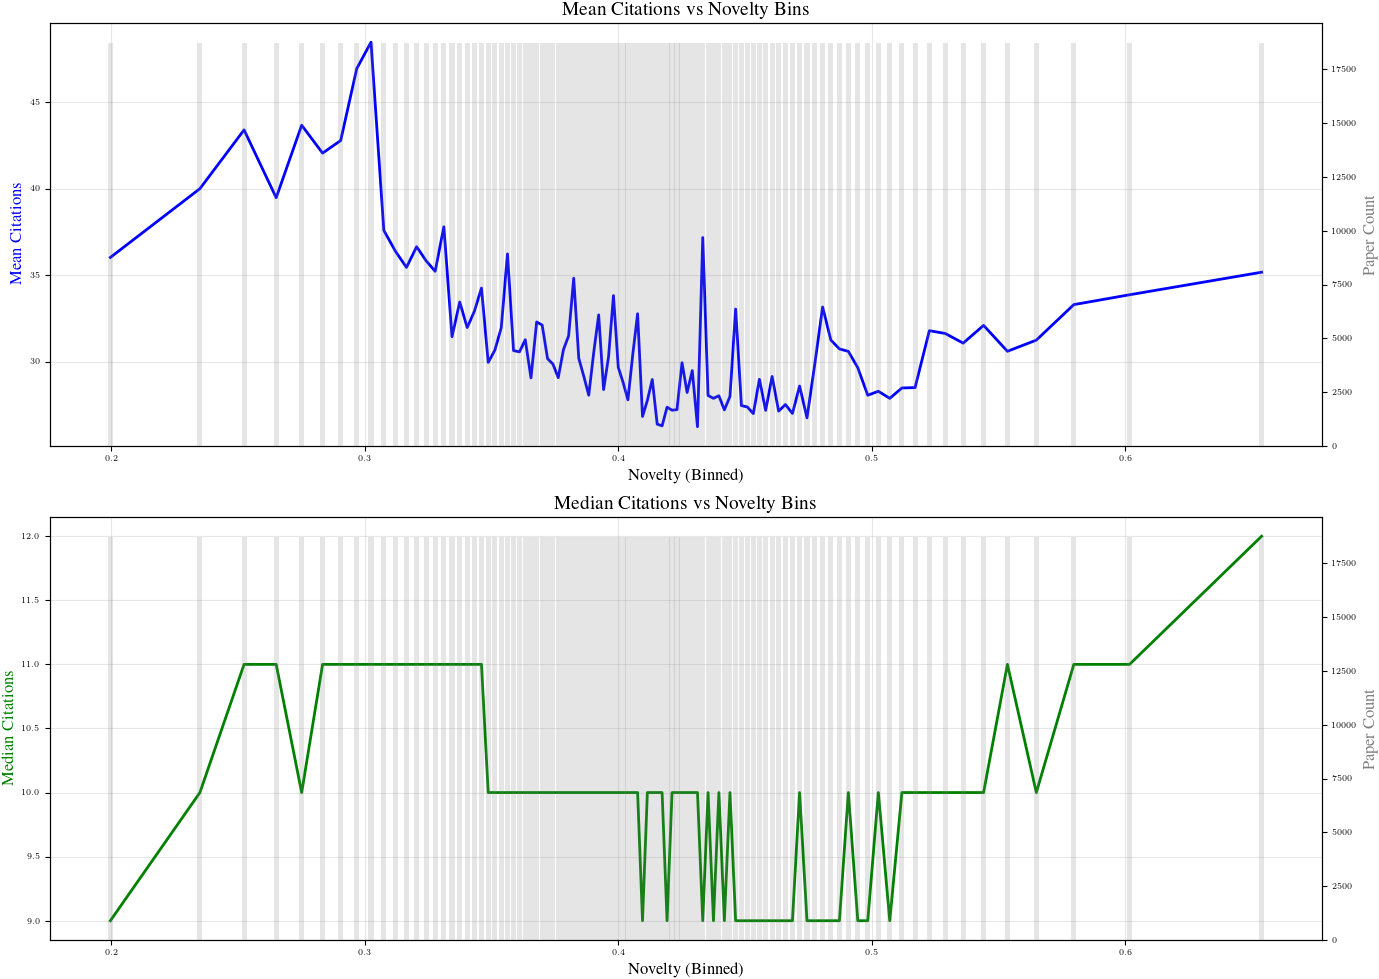

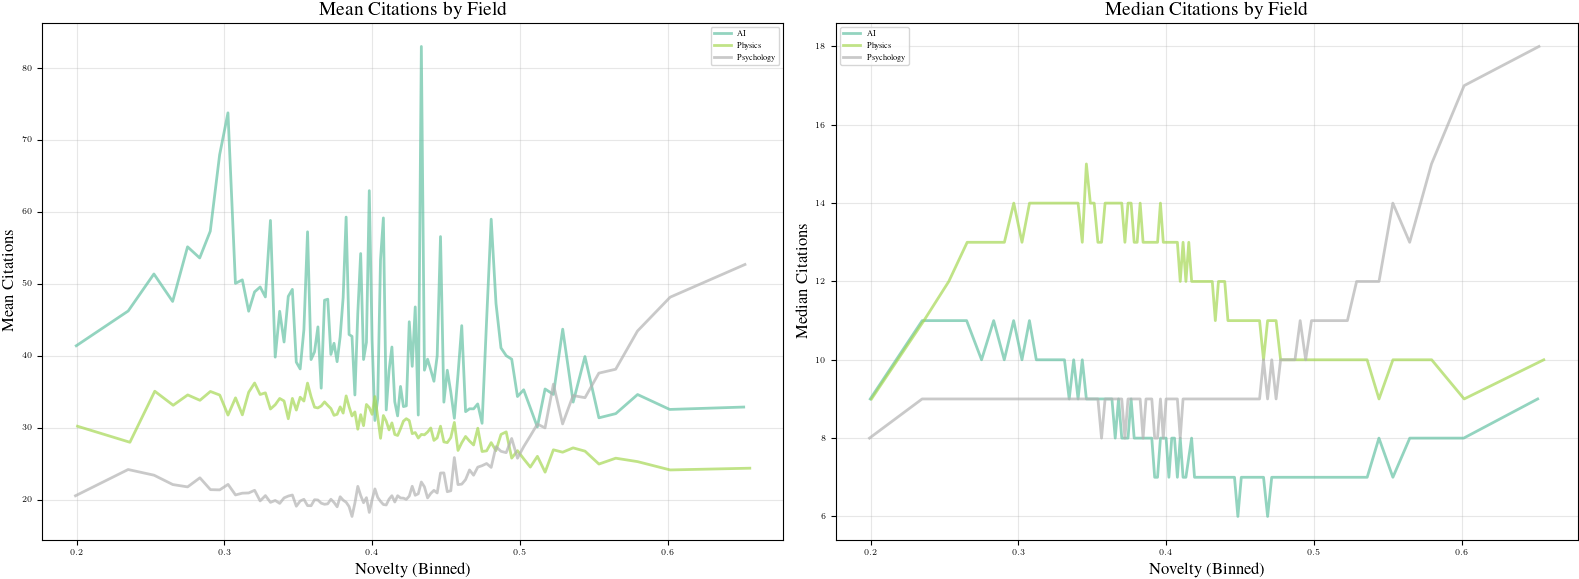

In [18]:
overall_stats, field_stats = create_novelty_bins(merged_df, n_bins=100)
fig1, fig2 = plot_novelty_bins(overall_stats, field_stats)
plt.show()

In [ ]:
def create_metric_bins_per_field(df, metric_col, n_bins=100):
    """Create bins per field for any metric and calculate novelty statistics.
    """
    df_clean = df[[NOVELTY_COL, metric_col, 'field']].dropna()
    fields = df_clean['field'].unique()
    field_stats = []
    
    for field in fields:
        field_data = df_clean[df_clean['field'] == field].copy()
        
        # Use rank-based binning to handle duplicates
        ranks = field_data[metric_col].rank(method='first')
        field_data['metric_bin'] = pd.qcut(ranks, q=n_bins, labels=False)
        
        # Calculate statistics
        field_bins = field_data.groupby('metric_bin').agg({
            NOVELTY_COL: ['mean', 'median', 'count', 'sem'],
            metric_col: 'mean'
        }).reset_index()
        field_bins.columns = ['bin', 'novelty_mean', 'novelty_median', 'count', 'novelty_sem', 'metric_avg']
        field_bins['field'] = field
        field_stats.append(field_bins)
    
    return pd.concat(field_stats, ignore_index=True)

### 5.2 Citation vs Novelty (Reverse Binning)

An alternative perspective: instead of binning by novelty and looking at citations, we can:
- **Bin by citation count** and examine the average novelty
- This reveals: "What novelty level characterizes highly-cited papers?"

This bidirectional analysis helps confirm whether relationships are robust to analysis choices.

In [24]:
def plot_metric_bins(field_stats, metric_name):
    """Plot metric bins analysis with error bars.
    
    Args:
        field_stats: DataFrame with binned statistics
        metric_name: Display name for the metric (e.g., 'Citation Count', 'Influential Citations')
    
    Returns:
        matplotlib Figure
    """
    fields = field_stats['field'].unique()
    n_fields = len(fields)
    
    fig, axes = plt.subplots(n_fields, 2, figsize=(16, 5*n_fields))
    if n_fields == 1:
        axes = axes.reshape(1, -1)
    
    for idx, field in enumerate(fields):
        field_data = field_stats[field_stats['field'] == field]
        
        # Mean novelty with error bars
        ax_left = axes[idx, 0]
        ax_left_twin = ax_left.twinx()
        ax_left.errorbar(field_data['metric_avg'], field_data['novelty_mean'], 
                        yerr=field_data['novelty_sem'], linewidth=2, color='purple', 
                        marker='o', markersize=3, capsize=2, alpha=0.8)
        width = field_data['metric_avg'].max()/200 if field_data['metric_avg'].max() > 0 else 0.1
        ax_left_twin.bar(field_data['metric_avg'], field_data['count'], 
                        alpha=0.2, color='gray', width=width)
        ax_left.set_xlabel(f'{metric_name} (Binned)', fontsize=11)
        ax_left.set_ylabel('Mean Novelty', fontsize=11, color='purple')
        ax_left_twin.set_ylabel('Paper Count', fontsize=10, color='gray')
        ax_left.set_title(f'{field} - Mean Novelty vs {metric_name}', fontsize=12, fontweight='bold')
        ax_left.grid(True, alpha=0.3)
        
        # Median novelty
        ax_right = axes[idx, 1]
        ax_right_twin = ax_right.twinx()
        ax_right.plot(field_data['metric_avg'], field_data['novelty_median'], 
                     linewidth=2, color='orange', marker='o', markersize=3)
        ax_right_twin.bar(field_data['metric_avg'], field_data['count'], 
                         alpha=0.2, color='gray', width=width)
        ax_right.set_xlabel(f'{metric_name} (Binned)', fontsize=11)
        ax_right.set_ylabel('Median Novelty', fontsize=11, color='orange')
        ax_right_twin.set_ylabel('Paper Count', fontsize=10, color='gray')
        ax_right.set_title(f'{field} - Median Novelty vs {metric_name}', fontsize=12, fontweight='bold')
        ax_right.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig.suptitle(f'Novelty vs {metric_name} by Field', fontsize=16, fontweight='bold', y=1.01)
    return fig

=== Citation Count Bins ===


/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_49046/3825015994.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


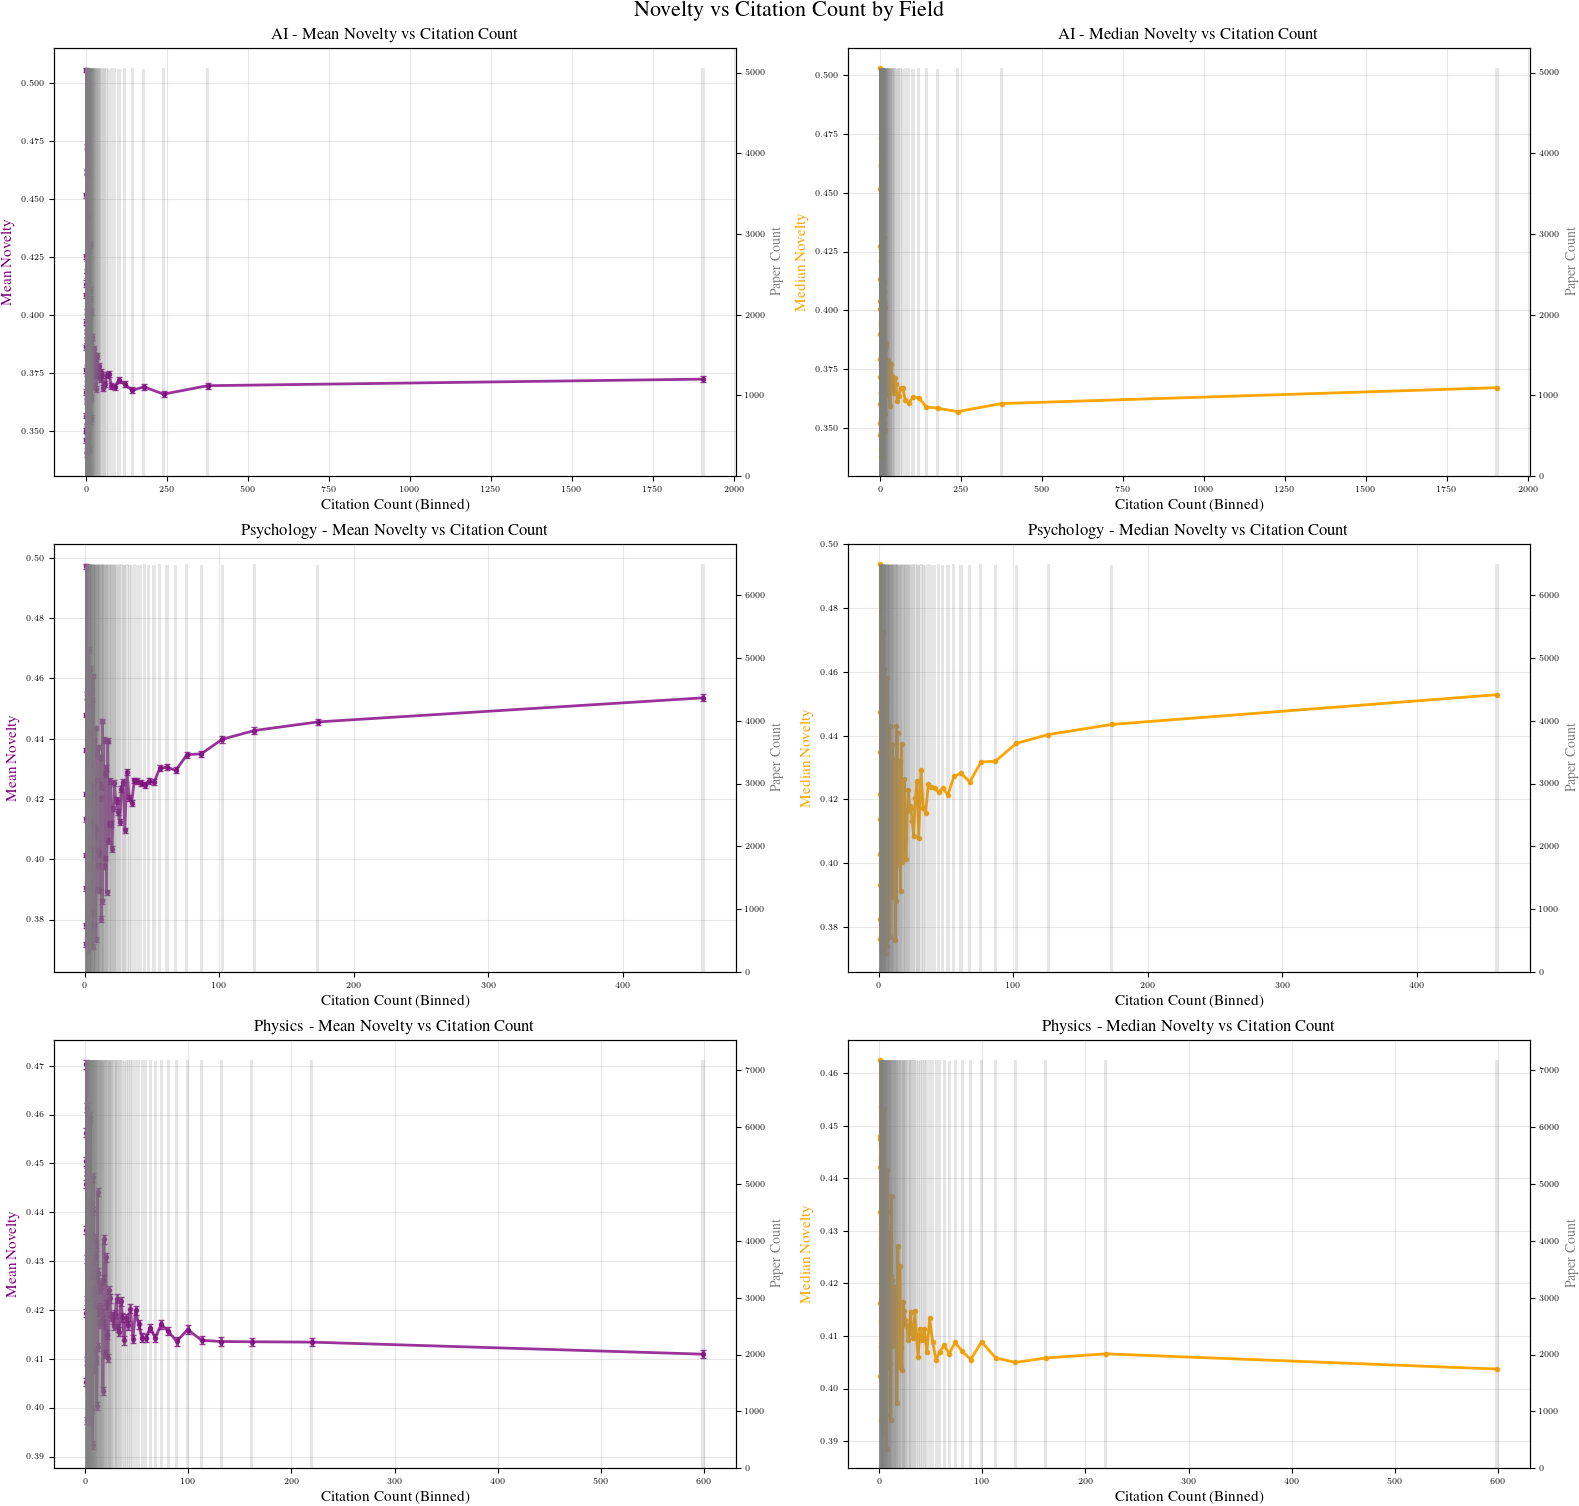

In [25]:
# Citation Count Bins
print("=== Citation Count Bins ===")
citation_stats = create_metric_bins_per_field(merged_df, CITATION_COL, n_bins=100)
fig = plot_metric_bins(citation_stats, 'Citation Count')
plt.show()

### 5.3 Global vs Per-Field Binning

Two binning strategies are compared:

**Global Binning**:
- Create novelty bins using the full dataset
- Apply same bin boundaries across all fields
- Advantage: Direct comparability of novelty values across fields

**Per-Field Binning**:
- Create novelty bins separately within each field
- Each field has its own bin boundaries
- Advantage: Accounts for field-specific novelty distributions

In [26]:
def create_novelty_bins_for_citations(df, n_bins=100, binning='global'):
    """Bin by novelty and calculate citation statistics.
    
    Args:
        df: DataFrame with data
        n_bins: Number of bins to create
        binning: 'global' (bin all data together) or 'per_field' (bin each field separately)
    
    Returns:
        DataFrame with binned statistics per field
    """
    df_clean = df[[NOVELTY_COL, CITATION_COL, 'field']].dropna().copy()
    fields = df_clean['field'].unique()
    field_stats = []
    
    if binning == 'global':
        # Create global bins based on all data
        ranks = df_clean[NOVELTY_COL].rank(method='first')
        df_clean['novelty_bin'] = pd.qcut(ranks, q=n_bins, labels=False)
        
        # Then calculate stats per field within global bins
        for field in fields:
            field_data = df_clean[df_clean['field'] == field]
            field_bins = field_data.groupby('novelty_bin').agg({
                CITATION_COL: ['mean', 'median', 'count', 'sem'],
                NOVELTY_COL: 'mean'
            }).reset_index()
            field_bins.columns = ['bin', 'citation_mean', 'citation_median', 'count', 'citation_sem', 'novelty_avg']
            field_bins['field'] = field
            field_stats.append(field_bins)
    else:  # per_field
        for field in fields:
            field_data = df_clean[df_clean['field'] == field].copy()
            ranks = field_data[NOVELTY_COL].rank(method='first')
            field_data['novelty_bin'] = pd.qcut(ranks, q=n_bins, labels=False)
            
            field_bins = field_data.groupby('novelty_bin').agg({
                CITATION_COL: ['mean', 'median', 'count', 'sem'],
                NOVELTY_COL: 'mean'
            }).reset_index()
            field_bins.columns = ['bin', 'citation_mean', 'citation_median', 'count', 'citation_sem', 'novelty_avg']
            field_bins['field'] = field
            field_stats.append(field_bins)
    
    return pd.concat(field_stats, ignore_index=True)


def plot_citation_vs_novelty_bins(field_stats, title_suffix=''):
    """Plot citation vs novelty bins with paper count on secondary y-axis.
    
    Args:
        field_stats: DataFrame with binned statistics
        title_suffix: Additional text for the title (e.g., 'Global Binning')
    
    Returns:
        matplotlib Figure
    """
    fields = ['AI', 'Physics', 'Psychology']
    colors = {'AI': '#A23B72', 'Physics': '#2E86AB', 'Psychology': '#F18F01', 'Other': '#666666'}
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    
    for idx, field in enumerate(fields):
        field_data = field_stats[field_stats['field'] == field].sort_values('novelty_avg')
        if len(field_data) == 0:
            continue
        color = colors.get(field, '#333333')
        
        # Mean citations (left column)
        ax_left = axes[idx, 0]
        ax_left_twin = ax_left.twinx()
        ax_left.fill_between(field_data['novelty_avg'], 
                            field_data['citation_mean'] - field_data['citation_sem'],
                            field_data['citation_mean'] + field_data['citation_sem'],
                            alpha=0.3, color=color)
        ax_left.plot(field_data['novelty_avg'], field_data['citation_mean'], 
                    linewidth=2, color=color)
        ax_left_twin.bar(field_data['novelty_avg'], field_data['count'], 
                        alpha=0.15, color='gray', width=0.003)
        
        ax_left.set_xlabel('Novelty (Binned)', fontsize=11)
        ax_left.set_ylabel('Mean Citation Count', fontsize=11, color=color)
        ax_left_twin.set_ylabel('Paper Count', fontsize=10, color='gray')
        ax_left_twin.tick_params(axis='y', labelcolor='gray')
        ax_left.set_title(f'{field} - Mean Citations {title_suffix}', fontsize=12, fontweight='bold')
        ax_left.grid(True, alpha=0.3, linestyle='--')
        # ax_left.set_yscale('log')
        
        # Median citations (right column)
        ax_right = axes[idx, 1]
        ax_right_twin = ax_right.twinx()
        ax_right.plot(field_data['novelty_avg'], field_data['citation_median'], 
                     linewidth=2, color=color)
        ax_right_twin.bar(field_data['novelty_avg'], field_data['count'], 
                         alpha=0.15, color='gray', width=0.003)
        
        ax_right.set_xlabel('Novelty (Binned)', fontsize=11)
        ax_right.set_ylabel('Median Citation Count', fontsize=11, color=color)
        ax_right_twin.set_ylabel('Paper Count', fontsize=10, color='gray')
        ax_right_twin.tick_params(axis='y', labelcolor='gray')
        ax_right.set_title(f'{field} - Median Citations {title_suffix}', fontsize=12, fontweight='bold')
        ax_right.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    fig.suptitle(f'Citations vs Novelty {title_suffix}', fontsize=14, fontweight='bold', y=1.01)
    return fig

=== Citation vs Novelty (Global Binning) ===


/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_49046/277725089.py:104: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


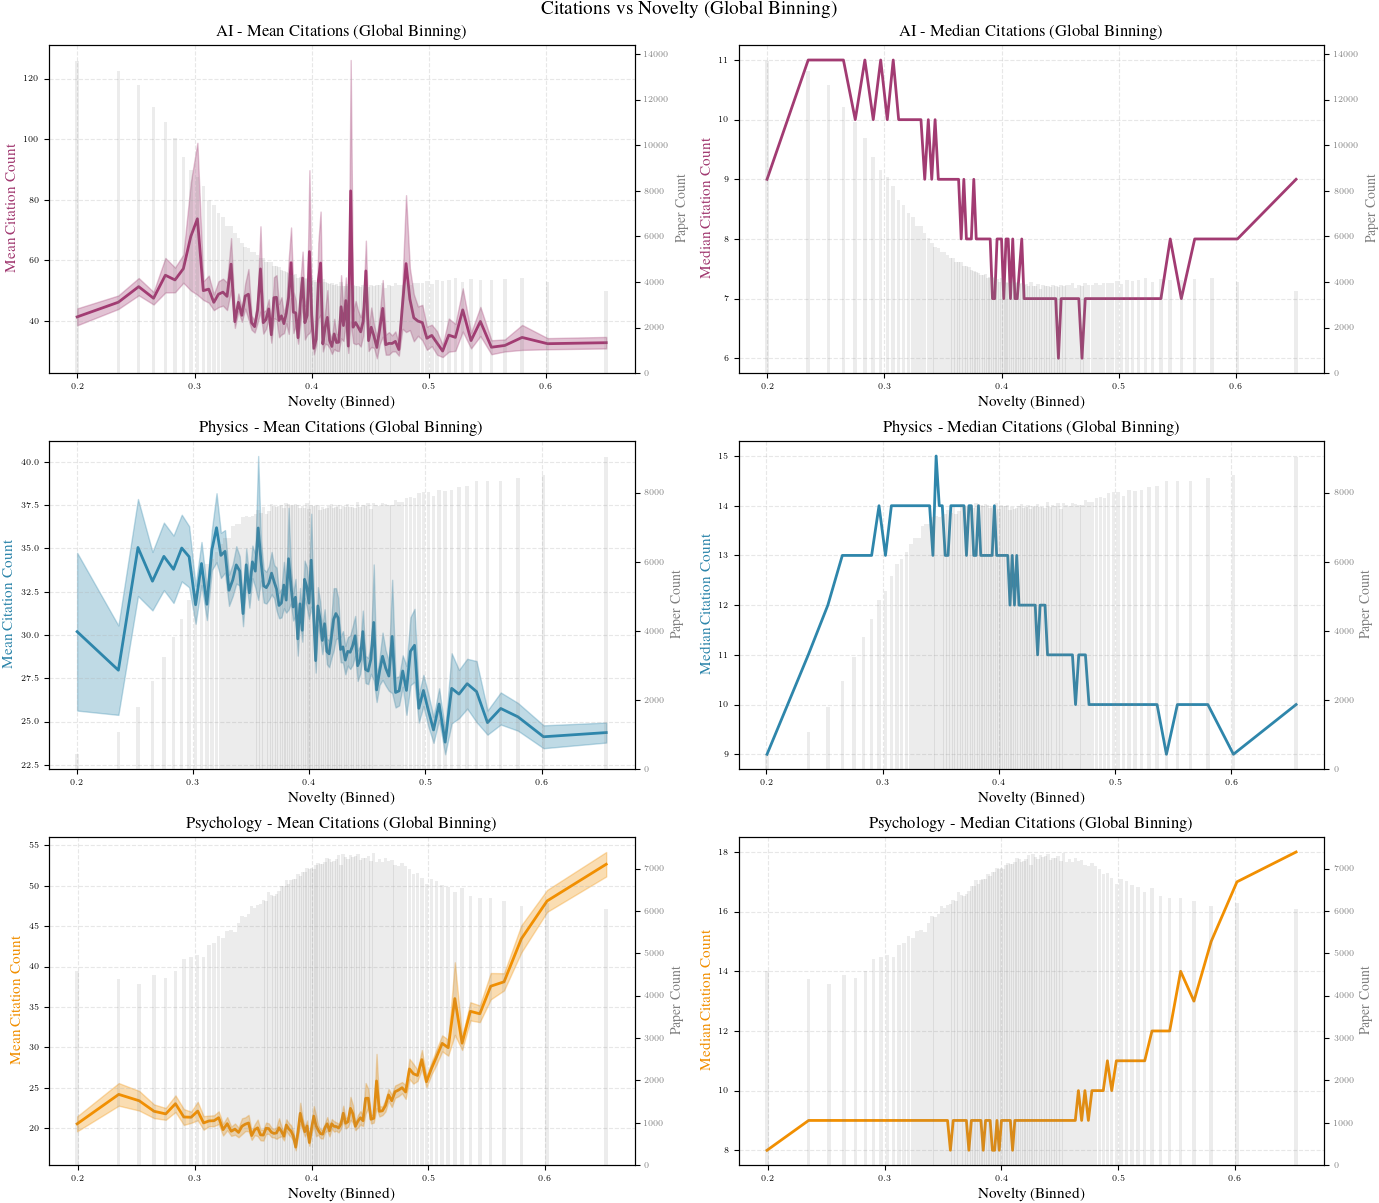

In [27]:
# Citation vs Novelty - Global Binning
print("=== Citation vs Novelty (Global Binning) ===")
citation_novelty_global = create_novelty_bins_for_citations(merged_df, n_bins=100, binning='global')
fig = plot_citation_vs_novelty_bins(citation_novelty_global, '(Global Binning)')
plt.show()

=== Citation vs Novelty (Per-Field Binning) ===


/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_49046/277725089.py:104: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


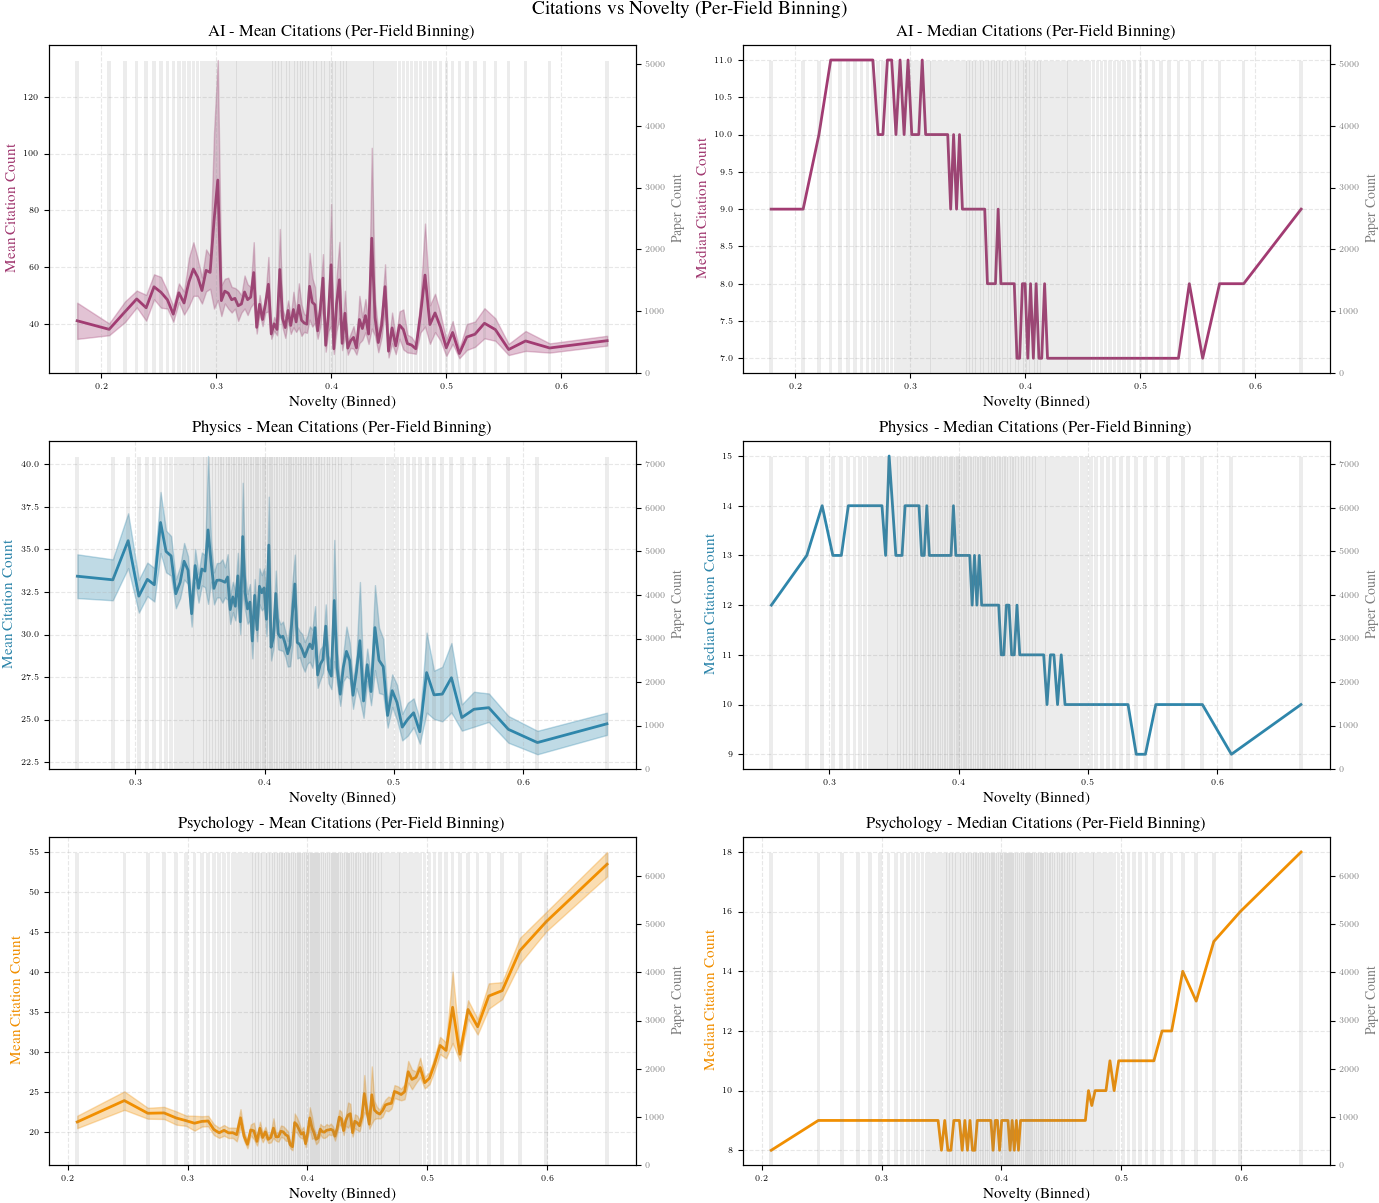

In [28]:
# Citation vs Novelty - Per-Field Binning
print("=== Citation vs Novelty (Per-Field Binning) ===")
citation_novelty_perfield = create_novelty_bins_for_citations(merged_df, n_bins=100, binning='per_field')
fig = plot_citation_vs_novelty_bins(citation_novelty_perfield, '(Per-Field Binning)')
plt.show()

---

## 6. Fixed-Width Binning with Bootstrapped Confidence Intervals

### 6.1 Robust Statistical Analysis

For the **main publication figures**, we employ a more rigorous binning approach:

**Fixed-Width Bins**:
- Bins have equal width in novelty space (not equal frequency)
- Edge bins (P0.1 and P99.9) capture extreme papers separately
- Provides interpretable x-axis (actual novelty values)

**Bootstrapped 95% Confidence Intervals**:
- 1000 bootstrap resamples per bin
- Non-parametric uncertainty estimation
- Robust to non-normal citation distributions

**Dual Visualization**:
- **Left panels**: Scatter plots colored by publication year (temporal trends)
- **Right panels**: Binned mean citations with CI bands

> **Figure Output**: This visualization is saved as `viz/novelty_vs_citations_fixed_width_bins.pdf` for publication.

=== Citation vs Novelty: Flexible Fixed-Width Bins (Per-Field Cutoffs) ===

AI - Cutoffs based on P0.1 and P99.9:
  Low cutoff (P0.1): 0.156979
  High cutoff (P99.9): 0.683849
  Data range: [0.018653, 0.936651]
  Bin width: 0.005269

Physics - Cutoffs based on P0.1 and P99.9:
  Low cutoff (P0.1): 0.231934
  High cutoff (P99.9): 0.711895
  Data range: [0.000000, 0.978305]
  Bin width: 0.004800

Psychology - Cutoffs based on P0.1 and P99.9:
  Low cutoff (P0.1): 0.177721
  High cutoff (P99.9): 0.694111
  Data range: [0.012886, 1.000000]
  Bin width: 0.005164

AI: Papers in Low (<P0.1): 506, in [P0.1-P99.9]: 504,057, in High (>P99.9): 506

Physics: Papers in Low (<P0.1): 718, in [P0.1-P99.9]: 716,055, in High (>P99.9): 718

Psychology: Papers in Low (<P0.1): 649, in [P0.1-P99.9]: 647,238, in High (>P99.9): 649


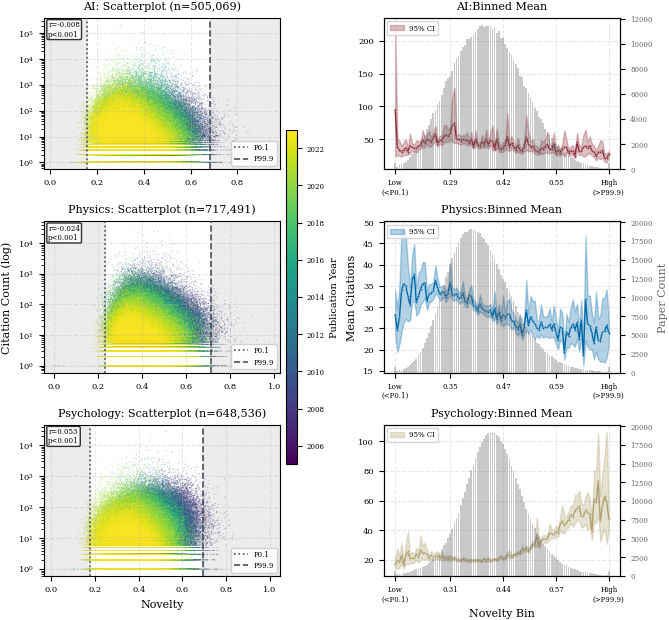

In [ ]:
# Fixed-width binning analysis with flexible error visualization and edge bin options
def bootstrap_ci(data, n_bootstrap=1000, ci=95, statistic=np.mean):
    """Calculate bootstrapped confidence interval."""
    data = np.array(data)
    data = data[~np.isnan(data)]
    
    if len(data) == 0:
        return np.nan, np.nan, np.nan
    
    if len(data) == 1:
        return data[0], data[0], data[0]
    
    boot_stats = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_stats.append(statistic(sample))
    
    boot_stats = np.array(boot_stats)
    alpha = (100 - ci) / 2
    lower = np.percentile(boot_stats, alpha)
    upper = np.percentile(boot_stats, 100 - alpha)
    point_est = statistic(data)
    
    return lower, upper, point_est


def compute_fixed_width_bins_flexible(df, n_bins=100, low_percentile=1, high_percentile=99, 
                                       collect_edge_bins=True, n_bootstrap=1000, ci=95):
    """Compute citation statistics using fixed-width novelty bins PER FIELD."""
    fields = ['AI', 'Physics', 'Psychology']
    df_clean = df[[NOVELTY_COL, CITATION_COL, 'field', 'publication_year']].dropna().copy()
    
    all_stats = []
    field_cutoffs = {}  # Store cutoffs per field
    field_bin_edges = {}  # Store bin edges per field
    
    for field in fields:
        field_data = df_clean[df_clean['field'] == field].copy()
        if len(field_data) == 0:
            continue
        
        # Calculate cutoffs PER FIELD
        low_cutoff = field_data[NOVELTY_COL].quantile(low_percentile / 100)
        high_cutoff = field_data[NOVELTY_COL].quantile(high_percentile / 100)
        
        field_cutoffs[field] = (low_cutoff, high_cutoff)
        
        print(f"\n{field} - Cutoffs based on P{low_percentile} and P{high_percentile}:")
        print(f"  Low cutoff (P{low_percentile}): {low_cutoff:.6f}")
        print(f"  High cutoff (P{high_percentile}): {high_cutoff:.6f}")
        print(f"  Data range: [{field_data[NOVELTY_COL].min():.6f}, {field_data[NOVELTY_COL].max():.6f}]")
        
        if collect_edge_bins:
            main_bin_edges = np.linspace(low_cutoff, high_cutoff, n_bins + 1)
            bin_width = (high_cutoff - low_cutoff) / n_bins
        else:
            data_min = field_data[NOVELTY_COL].min()
            data_max = field_data[NOVELTY_COL].max()
            main_bin_edges = np.linspace(data_min, data_max, n_bins + 1)
            bin_width = (data_max - data_min) / n_bins
        
        field_bin_edges[field] = main_bin_edges
        print(f"  Bin width: {bin_width:.6f}")
        
        if collect_edge_bins:
            def assign_bin(x):
                if x < low_cutoff:
                    return -1
                elif x > high_cutoff:
                    return n_bins
                else:
                    bin_idx = np.searchsorted(main_bin_edges, x, side='right') - 1
                    return max(0, min(n_bins - 1, bin_idx))
        else:
            def assign_bin(x):
                bin_idx = np.searchsorted(main_bin_edges, x, side='right') - 1
                return max(0, min(n_bins - 1, bin_idx))
        
        field_data['novelty_bin'] = field_data[NOVELTY_COL].apply(assign_bin)
        
        if collect_edge_bins:
            low_edge_data = field_data[field_data['novelty_bin'] == -1]
            if len(low_edge_data) > 0:
                citations = low_edge_data[CITATION_COL]
                novelty_vals = low_edge_data[NOVELTY_COL]
                ci_lower, ci_upper, citation_mean = bootstrap_ci(citations.values, n_bootstrap=n_bootstrap, ci=ci)
                n = len(low_edge_data)
                std = citations.std()
                sem = std / np.sqrt(n) if n > 0 else np.nan
                all_stats.append({
                    'field': field,
                    'bin': -1,
                    'bin_label': f'<{low_cutoff:.3f}',
                    'bin_center': field_data[NOVELTY_COL].min() + (low_cutoff - field_data[NOVELTY_COL].min()) / 2,
                    'novelty_avg': novelty_vals.mean(),
                    'citation_mean': citation_mean,
                    'citation_median': citations.median(),
                    'citation_std': std,
                    'citation_sem': sem,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'count': n
                })
        
        for bin_num in range(n_bins):
            bin_data = field_data[field_data['novelty_bin'] == bin_num]
            if len(bin_data) > 0:
                citations = bin_data[CITATION_COL]
                novelty_vals = bin_data[NOVELTY_COL]
                bin_center = (main_bin_edges[bin_num] + main_bin_edges[bin_num + 1]) / 2
                ci_lower, ci_upper, citation_mean = bootstrap_ci(citations.values, n_bootstrap=n_bootstrap, ci=ci)
                n = len(bin_data)
                std = citations.std()
                sem = std / np.sqrt(n) if n > 0 else np.nan
                
                all_stats.append({
                    'field': field,
                    'bin': bin_num,
                    'bin_label': f'{main_bin_edges[bin_num]:.4f}',
                    'bin_center': bin_center,
                    'novelty_avg': novelty_vals.mean(),
                    'citation_mean': citation_mean,
                    'citation_median': citations.median(),
                    'citation_std': std,
                    'citation_sem': sem,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'count': n
                })
        
        if collect_edge_bins:
            high_edge_data = field_data[field_data['novelty_bin'] == n_bins]
            if len(high_edge_data) > 0:
                citations = high_edge_data[CITATION_COL]
                novelty_vals = high_edge_data[NOVELTY_COL]
                ci_lower, ci_upper, citation_mean = bootstrap_ci(citations.values, n_bootstrap=n_bootstrap, ci=ci)
                n = len(high_edge_data)
                std = citations.std()
                sem = std / np.sqrt(n) if n > 0 else np.nan
                all_stats.append({
                    'field': field,
                    'bin': n_bins,
                    'bin_label': f'>{high_cutoff:.3f}',
                    'bin_center': high_cutoff + (field_data[NOVELTY_COL].max() - high_cutoff) / 2,
                    'novelty_avg': novelty_vals.mean(),
                    'citation_mean': citation_mean,
                    'citation_median': citations.median(),
                    'citation_std': std,
                    'citation_sem': sem,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'count': n
                })
    
    return pd.DataFrame(all_stats), field_bin_edges, field_cutoffs


def plot_fixed_width_bins_flexible(df, n_bins=100, low_percentile=1, high_percentile=99, 
                                    collect_edge_bins=True, error_type='ci', use_fill=True,
                                    title_suffix='', n_bootstrap=1000, ci=95):
    """Plot mean citations vs novelty with flexible error visualization using tueplots."""
    
    
    fields = ['AI', 'Physics', 'Psychology']
    
    # Convert rgb tuples to proper color format
    color_red = tuple(rgb.tue_red)
    color_blue = tuple(rgb.tue_blue)
    color_gold = tuple(rgb.tue_gold)
    color_gray = (0.4, 0.4, 0.4)  # Darker gray for paper count bars
    color_dark = tuple(rgb.tue_dark) if hasattr(rgb, 'tue_dark') else (0.2, 0.2, 0.2)
    
    colors = {
        'AI': color_red,
        'Physics': color_blue,
        'Psychology': color_gold
    }
    
    # Compute fixed-width bin statistics (now per field)
    stats_df, field_bin_edges, field_cutoffs = compute_fixed_width_bins_flexible(
        df, n_bins=n_bins, low_percentile=low_percentile, high_percentile=high_percentile,
        collect_edge_bins=collect_edge_bins, n_bootstrap=n_bootstrap, ci=ci
    )
    
    # Apply tueplots ICML 2024 style
    plt.rcParams.update(bundles.icml2024(column="full", nrows=3, ncols=2))
    plt.rcParams['text.usetex'] = False
    fig, axes = plt.subplots(3, 2, layout='constrained')
    
    # Prepare scatter data - include publication_year
    df_clean = df[[NOVELTY_COL, CITATION_COL, 'field', 'publication_year']].dropna().copy()
    
    # Get year range for colormap
    year_min = df_clean['publication_year'].min()
    year_max = df_clean['publication_year'].max()
    year_norm = plt.Normalize(year_min, year_max)
    year_cmap = plt.cm.viridis
    
    # Create a shared ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=year_norm)
    sm.set_array([])
    
    for idx, field in enumerate(fields):
        field_stats = stats_df[stats_df['field'] == field].sort_values('bin')
        field_scatter = df_clean[df_clean['field'] == field].copy()
        
        if len(field_stats) == 0 or len(field_scatter) == 0:
            continue
        
        # Get field-specific cutoffs and bin edges
        low_cutoff, high_cutoff = field_cutoffs[field]
        main_bin_edges = field_bin_edges[field]
        
        # Assign bins to scatter data using field-specific cutoffs
        if collect_edge_bins:
            def assign_bin(x):
                if x < low_cutoff:
                    return -1
                elif x > high_cutoff:
                    return n_bins
                else:
                    bin_idx = np.searchsorted(main_bin_edges, x, side='right') - 1
                    return max(0, min(n_bins - 1, bin_idx))
            norm = plt.Normalize(-1, n_bins)
        else:
            def assign_bin(x):
                bin_idx = np.searchsorted(main_bin_edges, x, side='right') - 1
                return max(0, min(n_bins - 1, bin_idx))
            norm = plt.Normalize(0, n_bins - 1)
        
        field_scatter['novelty_bin'] = field_scatter[NOVELTY_COL].apply(assign_bin)
        
        # LEFT: Scatter plot - color by publication year
        ax_left = axes[idx, 0]
        
        scatter = ax_left.scatter(
            field_scatter[NOVELTY_COL], 
            field_scatter[CITATION_COL],
            c=field_scatter['publication_year'],
            cmap='viridis',
            norm=year_norm,
            alpha=0.4,
            s=0.5,
            edgecolors='none',
            rasterized=True
        )
        
        if collect_edge_bins:
            # Different line styles for low and high percentile
            ax_left.axvline(x=low_cutoff, color=color_dark, alpha=0.9, linewidth=1.2, linestyle=':', zorder=5, 
                           label=f'P{low_percentile}')
            ax_left.axvline(x=high_cutoff, color=color_dark, alpha=0.9, linewidth=1.2, linestyle='--', zorder=5,
                           label=f'P{high_percentile}')
            
            xlim = ax_left.get_xlim()
            ax_left.axvspan(xlim[0], low_cutoff, alpha=0.12, color=color_gray)
            ax_left.axvspan(high_cutoff, xlim[1], alpha=0.12, color=color_gray)
            ax_left.set_xlim(xlim)
        
        # Only set ylabel for leftmost column
        if idx == 1:  # Middle row
            ax_left.set_ylabel('Citation Count (log)')
        
        ax_left.set_title(f'{field}: Scatterplot (n={len(field_scatter):,})')
        ax_left.set_yscale('log')
        ax_left.grid(True, alpha=0.3, linestyle='--')
        if collect_edge_bins:
            ax_left.legend(loc='lower right', fontsize=5, framealpha=0.9)
        
        # Correlation with p-value
        corr, p_value = scipy_stats.pearsonr(field_scatter[NOVELTY_COL], field_scatter[CITATION_COL])
        p_str = 'p<0.001' if p_value < 0.001 else f'p={p_value:.3f}'
        ax_left.text(0.02, 0.98, f'r={corr:.3f}\n{p_str}', transform=ax_left.transAxes, 
                    fontsize=5, va='top', ha='left', 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.2))
        
        # RIGHT: Mean citations with error visualization
        ax_right = axes[idx, 1]
        ax_right_twin = ax_right.twinx()
        
        x_positions = np.arange(len(field_stats))
        mean_vals = field_stats['citation_mean'].values
        bin_nums = field_stats['bin'].values
        count_vals = field_stats['count'].values
        
        # Determine error bounds based on error_type
        if error_type == 'std':
            error_lower = mean_vals - field_stats['citation_std'].values
            error_upper = mean_vals + field_stats['citation_std'].values
            error_vals = field_stats['citation_std'].values
            error_label = '±1 STD'
        elif error_type == 'sem':
            error_lower = mean_vals - field_stats['citation_sem'].values
            error_upper = mean_vals + field_stats['citation_sem'].values
            error_vals = field_stats['citation_sem'].values
            error_label = '±1 SEM'
        else:  # 'ci'
            error_lower = field_stats['ci_lower'].values
            error_upper = field_stats['ci_upper'].values
            error_vals = None
            error_label = f'{ci}% CI'
        
        # Draw line with field color
        ax_right.plot(x_positions, mean_vals, color=colors[field], linewidth=1.0)
        
        # Scatter points with field color - smaller markers
        ax_right.scatter(x_positions, mean_vals, 
                        c=[colors[field]], 
                        s=3, zorder=5, edgecolors='white', linewidth=0.2)
        
        # Error visualization
        if use_fill:
            ax_right.fill_between(x_positions, error_lower, error_upper, 
                                  alpha=0.3, color=colors[field], label=error_label)
        else:
            if error_type == 'ci':
                yerr_lower = mean_vals - error_lower
                yerr_upper = error_upper - mean_vals
                ax_right.errorbar(x_positions, mean_vals, 
                                 yerr=[yerr_lower, yerr_upper],
                                 fmt='none', color=colors[field], alpha=0.6, 
                                 capsize=1, capthick=0.5, label=error_label)
            else:
                ax_right.errorbar(x_positions, mean_vals, 
                                 yerr=error_vals,
                                 fmt='none', color=colors[field], alpha=0.6, 
                                 capsize=1, capthick=0.5, label=error_label)
        
        # Paper count bars - darker gray
        bar_width = 0.8
        ax_right_twin.bar(x_positions, count_vals, alpha=0.35, color=color_gray, width=bar_width)
        
        # Set x-tick labels with Low/High labels
        tick_positions = []
        tick_labels = []
        
        if collect_edge_bins:
            low_edge_pos = np.where(bin_nums == -1)[0]
            high_edge_pos = np.where(bin_nums == n_bins)[0]
            
            # Add Low label with percentile info
            if len(low_edge_pos) > 0:
                tick_positions.append(low_edge_pos[0])
                tick_labels.append(f'Low\n(<P{low_percentile})')
            
            main_bin_positions = np.where((bin_nums >= 0) & (bin_nums < n_bins))[0]
            if len(main_bin_positions) > 0:
                for i, pos in enumerate(main_bin_positions[1:]): #skip first bin for better readability
                    if bin_nums[pos] == 0 or bin_nums[pos] % 25 == 0:
                        tick_positions.append(pos)
                        tick_labels.append(f'{main_bin_edges[bin_nums[pos]]:.2f}')
            
            # Add High label with percentile info
            if len(high_edge_pos) > 0:
                tick_positions.append(high_edge_pos[0])
                tick_labels.append(f'High\n(>P{high_percentile})')
        else:
            interval = max(1, len(x_positions) // 10)
            for i in range(0, len(x_positions), interval):
                tick_positions.append(i)
                tick_labels.append(f'{main_bin_edges[bin_nums[i]]:.2f}')
        
        ax_right.set_xticks(tick_positions)
        ax_right.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=5)
        
        # Only set ylabel for middle row
        if idx == 1:
            ax_right.set_ylabel('Mean Citations')
            ax_right_twin.set_ylabel('Paper Count', color=color_gray)
        ax_right_twin.tick_params(axis='y', labelcolor=color_gray, labelsize=5)
        
        ax_right.set_title(f'{field}:Binned Mean')
        

        ax_right.grid(True, alpha=0.3, linestyle='--')
        ax_right.legend(loc='upper left', fontsize=5)
        
        
        
        # Print summary stats
        if collect_edge_bins:
            low_count = field_stats[field_stats['bin'] == -1]['count'].sum() if -1 in bin_nums else 0
            high_count = field_stats[field_stats['bin'] == n_bins]['count'].sum() if n_bins in bin_nums else 0
            main_count = field_stats[(field_stats['bin'] >= 0) & (field_stats['bin'] < n_bins)]['count'].sum()
            print(f"\n{field}: Papers in Low (<P{low_percentile}): {low_count:,}, "
                  f"in [P{low_percentile}-P{high_percentile}]: {main_count:,}, "
                  f"in High (>P{high_percentile}): {high_count:,}")
        else:
            total_count = field_stats['count'].sum()
            print(f"\n{field}: Total papers in {n_bins} bins: {total_count:,}")
    
    # Add common x-axis labels only for bottom row
    axes[2, 0].set_xlabel('Novelty')
    axes[2, 1].set_xlabel('Novelty Bin')
    
    # Add a single colorbar for publication year spanning all left plots
    cbar = fig.colorbar(sm, ax=axes[:, 0], shrink=0.6, pad=0.02, aspect=30, location='right')
    cbar.set_label('Publication Year', fontsize=7)
    cbar.ax.tick_params(labelsize=5)
    
    #plt.show()
    plt.savefig("viz/novelty_vs_citations_fixed_width_bins.pdf")
    return fig, stats_df


# Run with CI, fill_between, and edge bins
print("=== Citation vs Novelty: Flexible Fixed-Width Bins (Per-Field Cutoffs) ===")
fig_fixed, stats_fixed = plot_fixed_width_bins_flexible(
    merged_df, 
    n_bins=100, 
    low_percentile=0.1,
    high_percentile=99.9,
    collect_edge_bins=True,
    error_type='ci',
    use_fill=True,
    n_bootstrap=1000,
    ci=95
)

In [31]:
# # Fixed-width binning analysis - CUMULATIVE UP TO EACH YEAR
# def compute_fixed_width_bins_cumulative(df, n_bins=100, low_percentile=1, high_percentile=99, 
#                                          collect_edge_bins=True, n_bootstrap=1000, ci=95):
#     """Compute citation statistics using fixed-width novelty bins PER FIELD, CUMULATIVE UP TO EACH YEAR."""
#     fields = ['AI', 'Physics', 'Psychology']
#     df_clean = df[[NOVELTY_COL, CITATION_COL, 'field', 'publication_year']].dropna().copy()
    
#     all_stats = []
#     field_cutoffs = {}
#     field_bin_edges = {}
    
#     # Get unique years
#     years = sorted(df_clean['publication_year'].unique())
    
#     for field in fields:
#         field_data = df_clean[df_clean['field'] == field].copy()
#         if len(field_data) == 0:
#             continue
        
#         # Calculate cutoffs PER FIELD (across all years for consistency)
#         low_cutoff = field_data[NOVELTY_COL].quantile(low_percentile / 100)
#         high_cutoff = field_data[NOVELTY_COL].quantile(high_percentile / 100)
        
#         field_cutoffs[field] = (low_cutoff, high_cutoff)
        
#         print(f"\n{field} - Cutoffs based on P{low_percentile} and P{high_percentile}:")
#         print(f"  Low cutoff (P{low_percentile}): {low_cutoff:.6f}")
#         print(f"  High cutoff (P{high_percentile}): {high_cutoff:.6f}")
        
#         if collect_edge_bins:
#             main_bin_edges = np.linspace(low_cutoff, high_cutoff, n_bins + 1)
#         else:
#             data_min = field_data[NOVELTY_COL].min()
#             data_max = field_data[NOVELTY_COL].max()
#             main_bin_edges = np.linspace(data_min, data_max, n_bins + 1)
        
#         field_bin_edges[field] = main_bin_edges
        
#         # Process CUMULATIVE data up to each year
#         for year in years:
#             # CUMULATIVE: include all data up to and including this year
#             cumulative_data = field_data[field_data['publication_year'] <= year].copy()
#             if len(cumulative_data) == 0:
#                 continue
            
#             if collect_edge_bins:
#                 def assign_bin(x):
#                     if x < low_cutoff:
#                         return -1
#                     elif x > high_cutoff:
#                         return n_bins
#                     else:
#                         bin_idx = np.searchsorted(main_bin_edges, x, side='right') - 1
#                         return max(0, min(n_bins - 1, bin_idx))
#             else:
#                 def assign_bin(x):
#                     bin_idx = np.searchsorted(main_bin_edges, x, side='right') - 1
#                     return max(0, min(n_bins - 1, bin_idx))
            
#             cumulative_data['novelty_bin'] = cumulative_data[NOVELTY_COL].apply(assign_bin)
            
#             if collect_edge_bins:
#                 low_edge_data = cumulative_data[cumulative_data['novelty_bin'] == -1]
#                 if len(low_edge_data) > 0:
#                     citations = low_edge_data[CITATION_COL]
#                     novelty_vals = low_edge_data[NOVELTY_COL]
#                     ci_lower, ci_upper, citation_mean = bootstrap_ci(citations.values, n_bootstrap=n_bootstrap, ci=ci)
#                     n = len(low_edge_data)
#                     std = citations.std()
#                     sem = std / np.sqrt(n) if n > 0 else np.nan
#                     all_stats.append({
#                         'field': field,
#                         'year': year,
#                         'bin': -1,
#                         'bin_label': f'<{low_cutoff:.3f}',
#                         'bin_center': field_data[NOVELTY_COL].min() + (low_cutoff - field_data[NOVELTY_COL].min()) / 2,
#                         'novelty_avg': novelty_vals.mean(),
#                         'citation_mean': citation_mean,
#                         'citation_median': citations.median(),
#                         'citation_std': std,
#                         'citation_sem': sem,
#                         'ci_lower': ci_lower,
#                         'ci_upper': ci_upper,
#                         'count': n
#                     })
            
#             for bin_num in range(n_bins):
#                 bin_data = cumulative_data[cumulative_data['novelty_bin'] == bin_num]
#                 if len(bin_data) > 0:
#                     citations = bin_data[CITATION_COL]
#                     novelty_vals = bin_data[NOVELTY_COL]
#                     bin_center = (main_bin_edges[bin_num] + main_bin_edges[bin_num + 1]) / 2
#                     ci_lower, ci_upper, citation_mean = bootstrap_ci(citations.values, n_bootstrap=n_bootstrap, ci=ci)
#                     n = len(bin_data)
#                     std = citations.std()
#                     sem = std / np.sqrt(n) if n > 0 else np.nan
                    
#                     all_stats.append({
#                         'field': field,
#                         'year': year,
#                         'bin': bin_num,
#                         'bin_label': f'{main_bin_edges[bin_num]:.4f}',
#                         'bin_center': bin_center,
#                         'novelty_avg': novelty_vals.mean(),
#                         'citation_mean': citation_mean,
#                         'citation_median': citations.median(),
#                         'citation_std': std,
#                         'citation_sem': sem,
#                         'ci_lower': ci_lower,
#                         'ci_upper': ci_upper,
#                         'count': n
#                     })
            
#             if collect_edge_bins:
#                 high_edge_data = cumulative_data[cumulative_data['novelty_bin'] == n_bins]
#                 if len(high_edge_data) > 0:
#                     citations = high_edge_data[CITATION_COL]
#                     novelty_vals = high_edge_data[NOVELTY_COL]
#                     ci_lower, ci_upper, citation_mean = bootstrap_ci(citations.values, n_bootstrap=n_bootstrap, ci=ci)
#                     n = len(high_edge_data)
#                     std = citations.std()
#                     sem = std / np.sqrt(n) if n > 0 else np.nan
#                     all_stats.append({
#                         'field': field,
#                         'year': year,
#                         'bin': n_bins,
#                         'bin_label': f'>{high_cutoff:.3f}',
#                         'bin_center': high_cutoff + (field_data[NOVELTY_COL].max() - high_cutoff) / 2,
#                         'novelty_avg': novelty_vals.mean(),
#                         'citation_mean': citation_mean,
#                         'citation_median': citations.median(),
#                         'citation_std': std,
#                         'citation_sem': sem,
#                         'ci_lower': ci_lower,
#                         'ci_upper': ci_upper,
#                         'count': n
#                     })
    
#     return pd.DataFrame(all_stats), field_bin_edges, field_cutoffs, years


# def plot_fixed_width_bins_cumulative(df, n_bins=100, low_percentile=1, high_percentile=99, 
#                                       collect_edge_bins=True, error_type='ci', use_fill=True,
#                                       title_suffix='', n_bootstrap=1000, ci=95):
#     """Plot mean citations vs novelty - CUMULATIVE UP TO EACH YEAR using tueplots."""
#     from scipy import stats as scipy_stats
#     from tueplots import bundles
#     from tueplots.constants.color import rgb
    
#     fields = ['AI', 'Physics', 'Psychology']
    
#     # Convert rgb tuples to proper color format
#     color_red = tuple(rgb.tue_red)
#     color_blue = tuple(rgb.tue_blue)
#     color_gold = tuple(rgb.tue_gold)
#     color_gray = (0.4, 0.4, 0.4)
#     color_dark = tuple(rgb.tue_dark) if hasattr(rgb, 'tue_dark') else (0.2, 0.2, 0.2)
    
#     colors = {
#         'AI': color_red,
#         'Physics': color_blue,
#         'Psychology': color_gold
#     }
    
#     # Compute fixed-width bin statistics (cumulative up to each year)
#     stats_df, field_bin_edges, field_cutoffs, years = compute_fixed_width_bins_cumulative(
#         df, n_bins=n_bins, low_percentile=low_percentile, high_percentile=high_percentile,
#         collect_edge_bins=collect_edge_bins, n_bootstrap=n_bootstrap, ci=ci
#     )
    
#     years = sorted([int(y) for y in years])
#     n_years = len(years)
    
#     # Prepare scatter data
#     df_clean = df[[NOVELTY_COL, CITATION_COL, 'field', 'publication_year']].dropna().copy()
    
#     # Apply tueplots ICML 2024 style
#     plt.rcParams.update(bundles.icml2024(column="full", nrows=n_years, ncols=6))
#     plt.rcParams['text.usetex'] = False
#     fig, axes = plt.subplots(n_years, 6, figsize=(14, 2.5*n_years), layout='constrained')
    
#     # If only 1 year, axes won't be 2D
#     if n_years == 1:
#         axes = axes.reshape(1, -1)
    
#     for year_idx, year in enumerate(years):
#         # CUMULATIVE: include all data up to and including this year
#         cumulative_scatter_data = df_clean[df_clean['publication_year'] <= year]
        
#         for field_idx, field in enumerate(fields):
#             field_stats = stats_df[(stats_df['field'] == field) & (stats_df['year'] == year)].sort_values('bin')
#             field_scatter = cumulative_scatter_data[cumulative_scatter_data['field'] == field].copy()
            
#             col_scatter = field_idx * 2
#             col_mean = field_idx * 2 + 1
            
#             ax_left = axes[year_idx, col_scatter]
#             ax_right = axes[year_idx, col_mean]
            
#             if len(field_stats) == 0 or len(field_scatter) == 0:
#                 ax_left.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax_left.transAxes)
#                 ax_right.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax_right.transAxes)
#                 continue
            
#             # Get field-specific cutoffs and bin edges
#             low_cutoff, high_cutoff = field_cutoffs[field]
#             main_bin_edges = field_bin_edges[field]
            
#             # Assign bins to scatter data
#             if collect_edge_bins:
#                 def assign_bin(x):
#                     if x < low_cutoff:
#                         return -1
#                     elif x > high_cutoff:
#                         return n_bins
#                     else:
#                         bin_idx = np.searchsorted(main_bin_edges, x, side='right') - 1
#                         return max(0, min(n_bins - 1, bin_idx))
#             else:
#                 def assign_bin(x):
#                     bin_idx = np.searchsorted(main_bin_edges, x, side='right') - 1
#                     return max(0, min(n_bins - 1, bin_idx))
            
#             field_scatter['novelty_bin'] = field_scatter[NOVELTY_COL].apply(assign_bin)
            
#             # LEFT: Scatter plot - color by publication year within cumulative data
#             year_min = df_clean['publication_year'].min()
#             year_norm = plt.Normalize(year_min, year)
            
#             scatter = ax_left.scatter(
#                 field_scatter[NOVELTY_COL], 
#                 field_scatter[CITATION_COL],
#                 c=field_scatter['publication_year'],
#                 cmap='viridis',
#                 norm=year_norm,
#                 alpha=0.4,
#                 s=0.5,
#                 edgecolors='none',
#                 rasterized=True
#             )
            
#             if collect_edge_bins:
#                 ax_left.axvline(x=low_cutoff, color=color_dark, alpha=0.9, linewidth=1.2, linestyle=':', zorder=5)
#                 ax_left.axvline(x=high_cutoff, color=color_dark, alpha=0.9, linewidth=1.2, linestyle='--', zorder=5)
#                 xlim = ax_left.get_xlim()
#                 ax_left.axvspan(xlim[0], low_cutoff, alpha=0.12, color=color_gray)
#                 ax_left.axvspan(high_cutoff, xlim[1], alpha=0.12, color=color_gray)
#                 ax_left.set_xlim(xlim)
            
#             # Title: Field name only on first row
#             if year_idx == 0:
#                 ax_left.set_title(f'{field}', fontsize=8)
            
#             # Year label on left side (only for first column) - show cumulative range
#             if field_idx == 0:
#                 ax_left.set_ylabel(f'≤{int(year)}\nCitations (log)', fontsize=7)
            
#             ax_left.set_yscale('log')
#             ax_left.grid(True, alpha=0.3, linestyle='--')
            
#             # Correlation
#             if len(field_scatter) > 2:
#                 corr, p_value = scipy_stats.pearsonr(field_scatter[NOVELTY_COL], field_scatter[CITATION_COL])
#                 p_str = 'p<0.001' if p_value < 0.001 else f'p={p_value:.3f}'
#                 ax_left.text(0.02, 0.98, f'r={corr:.3f}\n{p_str}\nn={len(field_scatter):,}', 
#                             transform=ax_left.transAxes, 
#                             fontsize=4, va='top', ha='left', 
#                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.2))
            
#             # RIGHT: Mean citations with error visualization
#             ax_right_twin = ax_right.twinx()
            
#             x_positions = np.arange(len(field_stats))
#             mean_vals = field_stats['citation_mean'].values
#             bin_nums = field_stats['bin'].values
#             count_vals = field_stats['count'].values
            
#             # Determine error bounds
#             if error_type == 'std':
#                 error_lower = mean_vals - field_stats['citation_std'].values
#                 error_upper = mean_vals + field_stats['citation_std'].values
#                 error_label = '±1 STD'
#             elif error_type == 'sem':
#                 error_lower = mean_vals - field_stats['citation_sem'].values
#                 error_upper = mean_vals + field_stats['citation_sem'].values
#                 error_label = '±1 SEM'
#             else:  # 'ci'
#                 error_lower = field_stats['ci_lower'].values
#                 error_upper = field_stats['ci_upper'].values
#                 error_label = f'{ci}% CI'
            
#             # Draw line with field color
#             ax_right.plot(x_positions, mean_vals, color=colors[field], linewidth=1.0)
#             ax_right.scatter(x_positions, mean_vals, c=[colors[field]], s=3, zorder=5, 
#                             edgecolors='white', linewidth=0.2)
            
#             # Error visualization
#             if use_fill:
#                 ax_right.fill_between(x_positions, error_lower, error_upper, 
#                                       alpha=0.3, color=colors[field], label=error_label)
#             else:
#                 if error_type == 'ci':
#                     yerr_lower = mean_vals - error_lower
#                     yerr_upper = error_upper - mean_vals
#                     ax_right.errorbar(x_positions, mean_vals, yerr=[yerr_lower, yerr_upper],
#                                      fmt='none', color=colors[field], alpha=0.6, 
#                                      capsize=1, capthick=0.5, label=error_label)
#                 else:
#                     ax_right.errorbar(x_positions, mean_vals, yerr=error_vals,
#                                      fmt='none', color=colors[field], alpha=0.6, 
#                                      capsize=1, capthick=0.5, label=error_label)
            
#             # Paper count bars
#             bar_width = 0.8
#             ax_right_twin.bar(x_positions, count_vals, alpha=0.35, color=color_gray, width=bar_width)
            
#             # X-tick labels
#             tick_positions = []
#             tick_labels = []
            
#             if collect_edge_bins:
#                 low_edge_pos = np.where(bin_nums == -1)[0]
#                 high_edge_pos = np.where(bin_nums == n_bins)[0]
                
#                 if len(low_edge_pos) > 0:
#                     tick_positions.append(low_edge_pos[0])
#                     tick_labels.append('Low')
                
#                 main_bin_positions = np.where((bin_nums >= 0) & (bin_nums < n_bins))[0]
#                 if len(main_bin_positions) > 0:
#                     for i, pos in enumerate(main_bin_positions[1:]):
#                         if bin_nums[pos] == 0 or bin_nums[pos] % 25 == 0:
#                             tick_positions.append(pos)
#                             tick_labels.append(f'{main_bin_edges[bin_nums[pos]]:.2f}')
                
#                 if len(high_edge_pos) > 0:
#                     tick_positions.append(high_edge_pos[0])
#                     tick_labels.append('High')
#             else:
#                 interval = max(1, len(x_positions) // 5)
#                 for i in range(0, len(x_positions), interval):
#                     tick_positions.append(i)
#                     tick_labels.append(f'{main_bin_edges[bin_nums[i]]:.2f}')
            
#             ax_right.set_xticks(tick_positions)
#             ax_right.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=4)
            
#             if year_idx == 0:
#                 ax_right.set_title(f'{field} ({error_label})', fontsize=8)
            
#             ax_right_twin.tick_params(axis='y', labelcolor=color_gray, labelsize=4)
#             ax_right.tick_params(axis='y', labelsize=4)
#             ax_left.tick_params(axis='both', labelsize=4)
#             ax_right.grid(True, alpha=0.3, linestyle='--')
    
#     # Add common x-axis labels only for bottom row
#     for col in range(0, 6, 2):
#         axes[-1, col].set_xlabel('Novelty', fontsize=7)
#         axes[-1, col+1].set_xlabel('Novelty Bin', fontsize=7)
    
#     plt.savefig("fixed_width_bins_cumulative.pdf", dpi=150, bbox_inches='tight')
#     return fig, stats_df


# # Run the cumulative plot
# print("=== Citation vs Novelty: CUMULATIVE Up To Each Year ===")
# fig_cumulative, stats_cumulative = plot_fixed_width_bins_cumulative(
#     merged_df, 
#     n_bins=100, 
#     low_percentile=0.1,
#     high_percentile=99.9,
#     collect_edge_bins=True,
#     error_type='ci',
#     use_fill=True,
#     n_bootstrap=1000,
#     ci=95
# )

---

## 7. Case Study: Paper Neighborhood Visualization

### 7.1 Load AI Top Papers with t-SNE Embeddings

For a deeper understanding of how novelty relates to the **semantic landscape** of research, we analyze paper neighborhoods using t-SNE projections of SPECTER2 embeddings.

This data includes:
- 2D t-SNE coordinates for visualization
- Cosine distances to neighbors (in full 768D space)
- Citation and novelty metrics for each paper and its neighbors

In [40]:
# Top papers by citations
print("=== Top 10 Most Cited Papers ===")
top_cited_overall = merged_df.nlargest(10, CITATION_COL)[[
    'corpusid', 'title', CITATION_COL, NOVELTY_COL, 'field', 'publication_year'
]]
display(top_cited_overall)

# Top papers by novelty
print("\n=== Top 10 Most Novel Papers ===")
top_novel_overall = merged_df.nlargest(10, NOVELTY_COL)[[
    'corpusid', 'title', NOVELTY_COL, CITATION_COL, 'field', 'publication_year'
]]
display(top_novel_overall)

=== Top 10 Most Cited Papers ===


corpusid                                              title  \
624159   206594692       Deep Residual Learning for Image Recognition   
545632     6628106         Adam: A Method for Stochastic Optimization   
758871    13756489                          Attention is All you Need   
523994    14124313  Very Deep Convolutional Networks for Large-Sca...   
575290     3719281  U-Net: Convolutional Networks for Biomedical I...   
580126    10328909  Faster R-CNN: Towards Real-Time Object Detecti...   
1519796  225039882  An Image is Worth 16x16 Words: Transformers fo...   
1390438  218971783              Language Models are Few-Shot Learners   
526135   206592484                     Going deeper with convolutions   
644323     4650265           XGBoost: A Scalable Tree Boosting System   

         citation_count  novelty_mean field  publication_year  
624159           212958      0.301494    AI              2015  
545632           159525      0.434133    AI              2014  
758871           155623      0.297712    AI              2017  
523994           107085      0.398742    AI              2014  
575290            86900      0.481301    AI              2015  
580126            68158      0.355686    AI              2015  
1519796           52559      0.380971    AI              2020  
1390438           50503      0.331537    AI              2020  
526135            45792      0.405547    AI              2014  
644323            45470      0.407990    AI              2016


=== Top 10 Most Novel Papers ===


corpusid                                              title  \
103925    36632416    The Effects of Duct Shape on the Nusselt Number   
162514     6006608  Measurement of neutron induced fission of 235U...   
99055     16262271  A design of high speed double precision floati...   
108588    41595454  The 2 Tbps "data to surface" system of the CMS...   
128644   131512361        On Some Comet Observations in Ancient India   
1878164  248377127  LOv-Calculus: A Graphical Language for Linear ...   
773886   168953877  Comparison of Various Security Features of Gen...   
103657   124550809  A new pulse neutron detector used in the mixtu...   
136709    55128360  Spatial variation of dose rate from beta sourc...   
108596   123153549  Deployment and use of the ATLAS DAQ in the com...   

         novelty_mean  citation_count       field  publication_year  
103925       1.000000              19  Psychology              2005  
162514       0.978305               6     Physics              2007  
99055        0.936651               7          AI              2005  
108588       0.920020               7     Physics              2005  
128644       0.908593               2     Physics              2006  
1878164      0.905486              22          AI              2022  
773886       0.905340               4          AI              2017  
103657       0.902170               2     Physics              2005  
136709       0.895335              40     Physics              2006  
108596       0.880779               4     Physics              2005

In [ ]:
#this file is generated from 'tsne_per_paper.ipynb'
ai_top_papers = pd.read_csv('data/ai_top_papers_tsne_per_query.csv')
ai_top_papers.query_id = ai_top_papers.query_id.astype(str)
ai_top_papers_merged = ai_top_papers.merge(
    merged_df,
    left_on='title',
    right_on='title',
    how='left'
)
ai_top_papers_merged

x          y      type query_id  \
0      -1.349863  -1.654713     query  1023605   
1      -0.895953  -2.121089  neighbor  1023605   
2      -0.615728  -0.698985  neighbor  1023605   
3      -1.993905   1.048468  neighbor  1023605   
4      -1.847369   2.563065  neighbor  1023605   
...          ...        ...       ...      ...   
11780   1.994541  -6.411585  neighbor  6447277   
11781   1.820635   0.968764  neighbor  6447277   
11782   3.180607  -1.237798  neighbor  6447277   
11783   4.190481  10.455592  neighbor  6447277   
11784  11.168022   1.088666  neighbor  6447277   

                                                   title  cosine_distance  \
0      Inception-v4, Inception-ResNet and the Impact ...         0.000000   
1           Deep Residual Learning for Image Recognition         0.035079   
2      Resnet in Resnet: Generalizing Residual Archit...         0.053926   
3      Delving Deep into Rectifiers: Surpassing Human...         0.054637   
4      Fast and Accurate Deep Network Learning by Exp...         0.055968   
...                                                  ...              ...   
11780  Understanding Deep Architectures using a Recur...         0.078342   
11781  Relay Backpropagation for Effective Learning o...         0.078456   
11782               Do Deep Nets Really Need to be Deep?         0.078486   
11783  Understanding learned CNN features through Fil...         0.078525   
11784  Deep Learning with S-Shaped Rectified Linear A...         0.078649   

         color    corpus_id  cosine_similarity  novelty_mean  ...  \
0      #1f77b4    1023605.0                NaN      0.393881  ...   
1      #1f77b4  206594692.0                NaN      0.301494  ...   
2      #1f77b4   12585246.0                NaN      0.407711  ...   
3      #1f77b4   13740328.0                NaN      0.412374  ...   
4      #1f77b4    5273326.0                NaN      0.362318  ...   
...        ...          ...                ...           ...  ...   
11780  #17becf   18166574.0                NaN      0.513637  ...   
11781  #17becf  264649570.0                NaN      0.428926  ...   
11782  #17becf   11536917.0                NaN      0.481727  ...   
11783  #17becf   16598672.0                NaN      0.443601  ...   
11784  #17becf   10520992.0                NaN      0.471499  ...   

       novelty_harmonic     corpusid  citation_count  publication_date  \
0              0.071640    1023605.0         14899.0        2016-02-23   
1              0.055979  206594692.0        212958.0        2015-12-10   
2              0.073931   12585246.0           958.0        2016-02-18   
3              0.075024   13740328.0         19669.0        2015-02-06   
4              0.066452    5273326.0          5843.0        2015-11-23   
...                 ...          ...             ...               ...   
11780          0.091943   18166574.0           147.0        2013-12-06   
11781          0.078107  264649570.0           315.0        2015-12-18   
11782          0.086585   11536917.0          2189.0        2013-12-20   
11783          0.080649   16598672.0             2.0        2015-11-16   
11784          0.084679   10520992.0           230.0        2015-12-22   

       is_physics  is_ai is_psych  \
0           False   True    False   
1           False   True    False   
2            <NA>   True     <NA>   
3           False   True    False   
4            <NA>   True     <NA>   
...           ...    ...      ...   
11780        <NA>   True     <NA>   
11781        <NA>   True     <NA>   
11782        <NA>   True     <NA>   
11783        <NA>   True     <NA>   
11784       False   True    False   

                                           primary_topic publication_year  \
0                Domain Adaptation and Few-Shot Learning           2016.0   
1                   Advanced Neural Network Applications           2015.0   
2                   Advanced Neural Network Applications           2016.0   
3                 

### 7.2 Interactive Neighborhood Explorer: "Attention Is All You Need"

We perform a deep-dive into one of the most influential AI papers: **"Attention Is All You Need"** (Vaswani et al., 2017), which introduced the Transformer architecture.

This interactive visualization shows:
-  **Query paper** (red star): The focal paper
-  **Neighbors** (colored by citations): Papers in the semantic neighborhood
- **Info panels**: Statistics about the query paper, closest neighbor, most-cited neighbor

**Key Questions**:
- What prior work is most similar to Transformers?
- How do the citation patterns of neighbors compare to the breakthrough paper?
- What research threads converged to enable this breakthrough?

In [ ]:
# Interactive visualization: Explore specific paper neighborhoods with enhanced features
sample_query = '13756489' # Attention Is All You Need
query_data = ai_top_papers_merged[ai_top_papers_merged['query_id'] == str(sample_query)].copy()

# Use the actual 768-dimensional distance from the distance column
neighbors_data = query_data.iloc[1:].copy()
neighbors_data = neighbors_data.sort_values('cosine_distance')

# Get citation counts for color mapping
citation_counts = neighbors_data['citation_count'].fillna(0)
min_cit = citation_counts.min()
max_cit = citation_counts.max()

fig = go.Figure()

# Prepare neighbor hover text with paper info
neighbor_hovers = []
for idx, row in neighbors_data.iterrows():
    hover_text = f"<b>Neighbor Paper</b><br>"
    if 'title' in row and pd.notna(row['title']):
        hover_text += f"Title: {row['title']}<br>"
    if 'corpus_id' in row:
        hover_text += f"Corpus ID: {row['corpus_id']}<br>"
    if 'publication_year' in row:
        hover_text += f"Year: {row['publication_year']}<br>"
    if 'citation_count' in row and pd.notna(row['citation_count']):
        hover_text += f"Citations: {int(row['citation_count'])}<br>"
    if 'novelty_mean' in row:
        hover_text += f"Novelty: {row['novelty_mean']:.4f}<br>"
    if 'cosine_distance' in row:
        hover_text += f"Cosine Distance: {row['cosine_distance']:.4f}"
    neighbor_hovers.append(hover_text)

# Add neighbors with color-coded citations (heatmap style)
fig.add_trace(go.Scatter(
    x=neighbors_data['x'],
    y=neighbors_data['y'],
    mode='markers',
    name='Neighbors',
    marker=dict(
        size=12, 
        color=neighbors_data['citation_count'].fillna(0),
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(
            title="Citations",
            thickness=15,
            len=0.7,
            x=1.15
        ),
        line=dict(width=1, color='white'),
        cmin=min_cit,
        cmax=max_cit
    ),
    hovertemplate='%{text}<extra></extra>',
    text=neighbor_hovers
))

# Prepare query paper hover text
query_row = query_data.iloc[0]
query_hover = f"<b>Query Paper</b><br>"
if 'title' in query_row and pd.notna(query_row['title']):
    query_hover += f"Title: {query_row['title']}<br>"
if 'corpus_id' in query_row:
    query_hover += f"Corpus ID: {query_row['corpus_id']}<br>"
if 'publication_year' in query_row:
    query_hover += f"Year: {query_row['publication_year']}<br>"
if 'citation_count' in query_row and pd.notna(query_row['citation_count']):
    query_hover += f"Citations: {int(query_row['citation_count'])}<br>"
if 'novelty_mean' in query_row:
    query_hover += f"Novelty: {query_row['novelty_mean']:.4f}"

# Add query paper
fig.add_trace(go.Scatter(
    x=[query_data['x'].iloc[0]],
    y=[query_data['y'].iloc[0]],
    mode='markers',
    name='Query Paper',
    marker=dict(size=25, color='red', symbol='star', 
                line=dict(width=2, color='darkred')),
    hovertemplate='%{text}<extra></extra>',
    text=[query_hover]
))

# Add connecting lines with transparency based on distance
max_dist = neighbors_data['cosine_distance'].max()
for _, neighbor in neighbors_data.iterrows():
    opacity = 1 - (neighbor['cosine_distance'] / max_dist) * 0.7  # Closer = more opaque
    fig.add_trace(go.Scatter(
        x=[query_data['x'].iloc[0], neighbor['x']],
        y=[query_data['y'].iloc[0], neighbor['y']],
        mode='lines',
        line=dict(color='gray', width=0.5),
        opacity=opacity,
        showlegend=False,
        hoverinfo='skip'
    ))

# Create persistent info panel annotations for key papers
annotations = []

# Query paper info (top-left)
query_info = f"<b>QUERY PAPER</b><br>"
if pd.notna(query_row.get('title')):
    query_info += f"{query_row['title']}<br>"
query_info += f"Citations: {int(query_row.get('citation_count', 0))}<br>"
query_info += f"Novelty: {query_row.get('novelty_mean', 0):.4f}<br>"
query_info += f"Year: {int(query_row.get('publication_year', 0))}"

annotations.append(dict(
    x=0.02, y=0.98,
    xref='paper', yref='paper',
    text=query_info,
    showarrow=False,
    align='left',
    bgcolor='rgba(255, 200, 200, 0.9)',
    bordercolor='darkred',
    borderwidth=2,
    borderpad=8,
    font=dict(size=10, family='monospace')
))

# Closest neighbor info (top-right)
closest = neighbors_data.iloc[0]
closest_info = f"<b>CLOSEST NEIGHBOR</b><br>"
if pd.notna(closest.get('title')):
    closest_info += f"{closest['title']}<br>"
if pd.notna(closest.get('citation_count')):
    closest_info += f"Citations: {int(closest.get('citation_count', 0))}<br>" 
closest_info += f"Novelty: {closest.get('novelty_mean', 0):.4f}<br>"
closest_info += f"Cosine Distance: {closest['cosine_distance']:.4f}<br>"
if pd.notna(closest.get('publication_year')):
    closest_info += f"Year: {int(closest.get('publication_year', 0))}"

annotations.append(dict(
    x=0.98, y=0.98,
    xref='paper', yref='paper',
    text=closest_info,
    showarrow=False,
    align='left',
    bgcolor='rgba(200, 255, 200, 0.9)',
    bordercolor='darkgreen',
    borderwidth=2,
    borderpad=8,
    font=dict(size=10, family='monospace')
))

# Most cited neighbor info (bottom-left)
most_cited = neighbors_data.nlargest(1, 'citation_count').iloc[0]
cited_info = f"<b>MOST CITED NEIGHBOR</b><br>"
if pd.notna(most_cited.get('title')):
    cited_info += f"{most_cited['title']}.<br>" 
if pd.notna(most_cited.get('citation_count')):
    cited_info += f"Citations: {int(most_cited.get('citation_count', 0))}<br>"
cited_info += f"Novelty: {most_cited.get('novelty_mean', 0):.4f}<br>"
cited_info += f"Cosine Distance: {most_cited['cosine_distance']:.4f}<br>"
if pd.notna(most_cited.get('publication_year')):
    cited_info += f"Year: {int(most_cited.get('publication_year', 0))}"

annotations.append(dict(
    x=0.02, y=0.02,
    xref='paper', yref='paper',
    text=cited_info,
    showarrow=False,
    align='left',
    bgcolor='rgba(200, 200, 255, 0.9)',
    bordercolor='darkblue',
    borderwidth=2,
    borderpad=8,
    font=dict(size=10, family='monospace')
))

# Statistics box (bottom-right)
stats_info = f"<b>NEIGHBORHOOD STATS</b><br>"
stats_info += f"Total neighbors: {len(neighbors_data)}<br>"
stats_info += f"Avg cosine distance: {neighbors_data['cosine_distance'].mean():.4f}<br>"
stats_info += f"Avg citations: {neighbors_data['citation_count'].mean():.0f}<br>"
stats_info += f"Avg novelty: {neighbors_data['novelty_mean'].mean():.4f}"

annotations.append(dict(
    x=0.98, y=0.02,
    xref='paper', yref='paper',
    text=stats_info,
    showarrow=False,
    align='left',
    bgcolor='rgba(255, 255, 200, 0.9)',
    bordercolor='orange',
    borderwidth=2,
    borderpad=8,
    font=dict(size=10, family='monospace')
))

fig.update_layout(
    title=dict(
        text=f'Paper Neighborhood Analysis - Query {sample_query}<br><sub>Color intensity indicates citation count | Line opacity shows proximity (768-dim distance)</sub>',
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='Dimension 1',
    yaxis_title='Dimension 2',
    height=800,
    hovermode='closest',
    annotations=annotations,
    showlegend=True,
    legend=dict(
        x=0.5, y=-0.1,
        xanchor='center',
        orientation='h'
    ),
    margin=dict(l=50, r=150, t=100, b=50)
)

fig.show()

### 7.3 Publication-Quality t-SNE Visualization

This static visualization (suitable for publication) categorizes the neighbors of "Attention Is All You Need" by research theme:

| Category | Description |
|----------|-------------|
| **Attention** | Papers focusing on attention mechanisms |
| **Neural Machine Translation** | Sequence-to-sequence and encoder-decoder models |
| **RNNs** | Recurrent architectures (LSTM, GRU) |
| **Language Modelling** | NLP and word embedding approaches |
| **Other** | Papers not matching the above categories |

The visualization highlights the **most-cited paper from each category**, revealing which research threads the Transformer built upon.

> **Figure Output**: Saved as `viz/attention_is_all_you_need_neighbors.pdf`

/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_49046/372578603.py:161: UserWarning:

The figure layout has changed to tight



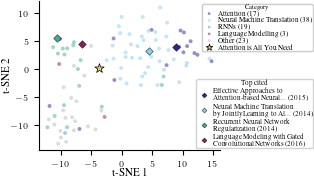

In [ ]:


# Use ICML 2024 bundle for half-column width
plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))

sample_query = '13756489' #Attention is all you need
query_data = ai_top_papers_merged[ai_top_papers_merged['query_id'] == str(sample_query)].copy()

# Get neighbors sorted by cosine distance (closest first)
neighbors_data = query_data.iloc[1:].copy()
neighbors_data = neighbors_data.sort_values('cosine_distance').reset_index(drop=True)

# Define keywords to categorize prior work themes
keyword_patterns = {
    'Attention': r'attention|self.attention|attend',
    'Neural Machine Translation': r'neural.*(machine\s+)?translat|sequence.to.sequence|seq2seq|encoder.decoder',
    'RNNs': r'recurrent|lstm|gru|rnn',
    'Language Modelling': r'language\s+model|word\s+embed|word2vec|nlp|natural\s+language',
}

def categorize_paper(title):
    if pd.isna(title):
        return 'Other'
    title_lower = title.lower()
    for category, pattern in keyword_patterns.items():
        if re.search(pattern, title_lower):
            return category
    return 'Other'

def wrap_title(title, width=28, max_lines=2):
    """Wrap title at word boundaries, max 2 lines with ellipsis if needed."""
    wrapped = textwrap.wrap(title, width=width)
    if len(wrapped) <= max_lines:
        return '\n'.join(wrapped)
    else:
        # Take first max_lines, add ellipsis to last line
        result = wrapped[:max_lines]
        if not result[-1].endswith('...'):
            result[-1] = result[-1][:width-3] + '...'
        return '\n'.join(result)

neighbors_data['category'] = neighbors_data['title'].apply(categorize_paper)

# Colorblind-friendly palette
category_colors = {
    'Attention': '#332288',
    'Neural Machine Translation': '#88CCEE',
    'RNNs': '#44AA99',
    'Language Modelling': '#882255',
    'Other': '#BBBBBB'
}

fig, ax = plt.subplots()

query_x = query_data['x'].iloc[0]
query_y = query_data['y'].iloc[0]

# Find top cited paper from each category (excluding Other)
top_cited_papers = []
for category in ['Attention', 'Neural Machine Translation', 'RNNs', 'Language Modelling']:
    cat_data = neighbors_data[neighbors_data['category'] == category]
    if len(cat_data) > 0 and 'citation_count' in cat_data.columns:
        top_paper = cat_data.loc[cat_data['citation_count'].idxmax()]
        top_cited_papers.append(top_paper)

# Plot neighbors grouped by category
for category in category_colors.keys():
    cat_data = neighbors_data[neighbors_data['category'] == category]
    if len(cat_data) == 0:
        continue
    
    ax.scatter(
        cat_data['x'], 
        cat_data['y'],
        s=8,
        c=category_colors[category],
        alpha=0.5,
        label=f"{category} ({len(cat_data)})",
        edgecolors='none',
        zorder=2
    )

# Highlight top cited papers with small diamond markers
top_handles, top_labels = [], []

for paper in top_cited_papers:
    category = paper['category']
    year = int(paper['publication_year']) if pd.notna(paper.get('publication_year')) else '?'

    citations = int(paper['citation_count']) if pd.notna(paper['citation_count']) else 0
    title = str(paper['title'])
    title_wrapped = wrap_title(title, width=28, max_lines=2)
    
    ax.scatter(
        [paper['x']], [paper['y']],
        s=15,
        c=category_colors[category],
        marker='D',
        edgecolors='black',
        linewidths=0.3,
        zorder=4
    )
    
    handle = Line2D([0], [0], marker='D', color='w', 
                    markerfacecolor=category_colors[category],
                    markeredgecolor='black', markeredgewidth=0.3,
                    markersize=2.5, linestyle='None')
    top_handles.append(handle)
    top_labels.append(f"{title_wrapped} ({year})")

# Plot query paper as a star
ax.scatter(
    [query_x], [query_y],
    s=50,
    c='#DDCC77',
    marker='*',
    edgecolors='black',
    linewidths=0.5,
    label='Attention is All You Need',
    zorder=5
)

ax.set_xlabel('t-SNE 1', labelpad=0.01)
ax.set_ylabel('t-SNE 2', labelpad=0.01)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Category legend (top right)
legend1 = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.88, 1),
    fontsize=5.2,
    frameon=True,
    framealpha=0.9,
    handletextpad=0.2,
    labelspacing=0.02,
    borderpad=0.02,
    markerscale=0.7,
    title = 'Category',
    title_fontsize=4.8
)
ax.add_artist(legend1)

# Top cited legend with paper names (bottom right)
legend2 = ax.legend(
    top_handles, top_labels,
    loc='upper left',
    bbox_to_anchor=(0.85, 0.50),
    fontsize=5.2,
    frameon=True,
    framealpha=0.9,
    handletextpad=0.2,
    labelspacing=0.2,
    borderpad=0.1,
    title='Top cited',
    title_fontsize=5.2
)
ax.add_artist(legend1)

plt.tight_layout()
fig.savefig('viz/attention_is_all_you_need_neighbors.pdf', bbox_inches='tight', dpi=300)
plt.show()

### 7.4 Multi-Paper Neighborhood Comparison

To examine whether the patterns observed for "Attention Is All You Need" generalize, we visualize neighborhoods for the **top AI papers by citation count**.

Each subplot shows:
-  **Query paper** (red star)
- **Neighbors** colored by citation count (viridis colormap)
- Paper title and citation count in the subplot title

This gallery view enables comparison of:
- Neighborhood density (isolated vs. well-connected papers)
- Citation distribution among neighbors
- Relative position of the query paper (central vs. peripheral)

In [ ]:
# Consolidated visualization: Multiple plots of 10 papers each, sorted by citation count


# Get unique papers and sort by citation count
papers_by_citation = ai_top_papers_merged.groupby('query_id').agg({
    'citation_count': 'first'
}).reset_index()
papers_by_citation = papers_by_citation.sort_values('citation_count', ascending=False)
sorted_queries = papers_by_citation['query_id'].values

# Create multiple plots, 12 papers per plot in 4x3 grid
papers_per_plot = 12
n_cols = 4
n_rows = 3
total_papers = len(sorted_queries)

# Generate plots in batches of 10
for plot_idx in range(0, total_papers, papers_per_plot):
    # Select 10 papers for this plot
    selected_queries = sorted_queries[plot_idx:plot_idx + papers_per_plot]
    n_papers = len(selected_queries)
    
    if n_papers == 0:
        break
    
    # Create subplot titles with paper titles (truncated)
    subplot_titles = []
    for query_id in selected_queries:
        query_paper = ai_top_papers_merged[ai_top_papers_merged['query_id'] == query_id].iloc[0]
        title = query_paper.get('title', f'Q{query_id}')
        if pd.notna(title):
            title = str(title)[:45] + "..." if len(title) > 45 else str(title)
        elif pd.isna(title):
            title = f'Q{query_id}'
        # Add citation count to title
        cite_count = int(query_paper.get('citation_count', 0))
        subplot_titles.append(f"{title}<br><sub>Citations: {cite_count}</sub>")
    
    # Pad with empty titles if fewer than 10 papers
    while len(subplot_titles) < papers_per_plot:
        subplot_titles.append("")
    
    # Create subplots
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        subplot_titles=subplot_titles,
        horizontal_spacing=0.02,
        vertical_spacing=0.08,
        specs=[[{'type': 'scatter'}] * n_cols for _ in range(n_rows)]
    )
    
    # Color palette for citation heatmap
    cmap = plt.colormaps['viridis']
    
    for idx, query_id in enumerate(selected_queries):
        row = idx // n_cols + 1
        col = idx % n_cols + 1
        
        query_data = ai_top_papers_merged[ai_top_papers_merged['query_id'] == query_id].copy()
        
        if len(query_data) < 2:
            continue
        
        # Get query point and neighbors
        query_point = query_data.iloc[0][['x', 'y']].values
        neighbors_data = query_data.iloc[1:].copy()
        neighbors_data = neighbors_data.sort_values('cosine_distance')
        
        # Get citation counts for color mapping
        citation_counts = neighbors_data['citation_count'].fillna(0)
        
        # Normalize citations to [0, 1] for color mapping
        if citation_counts.max() > 0:
            norm_citations = (citation_counts - citation_counts.min()) / (citation_counts.max() - citation_counts.min() + 1e-10)
        else:
            norm_citations = np.zeros(len(citation_counts))
        
        # Map to viridis colormap
        colors_list = [mcolors.rgb2hex(cmap(val)) for val in norm_citations]
        
        # Prepare hover texts
        neighbor_hovers = []
        for _, neighbor_row in neighbors_data.iterrows():
            hover = f"<b>Neighbor</b><br>"
            if pd.notna(neighbor_row.get('title')):
                hover += f"{neighbor_row['title']}<br>"
            cite_val = neighbor_row.get('citation_count', 0)
            hover += f"Cites: {int(cite_val) if pd.notna(cite_val) else 0}<br>" 
            hover += f"Nov: {neighbor_row.get('novelty_mean', 0):.3f}<br>"
            hover += f"Dist: {neighbor_row['cosine_distance']:.3f}<br>"
            hover += f"Year: {int(neighbor_row.get('publication_year', 0)) if pd.notna(neighbor_row.get('publication_year', 0)) else 'N/A'}"
            neighbor_hovers.append(hover)
        
        # # Add connecting lines (with distance-based opacity)
        # max_dist = neighbors_data['cosine_distance'].max() if len(neighbors_data) > 0 else 1
        # for _, neighbor in neighbors_data.iterrows():
        #     opacity = max(0.1, 1 - (neighbor['cosine_distance'] / max_dist) * 0.8)
        #     fig.add_trace(
        #         go.Scatter(
        #             x=[query_point[0], neighbor['x']],
        #             y=[query_point[1], neighbor['y']],
        #             mode='lines',
        #             line=dict(color='lightgray', width=0.3),
        #             opacity=opacity,
        #             showlegend=False,
        #             hoverinfo='skip'
        #         ),
        #         row=row, col=col
        #     )
        
        # Add neighbor points (color-coded by citations)
        for i, (_, neighbor) in enumerate(neighbors_data.iterrows()):
            fig.add_trace(
                go.Scatter(
                    x=[neighbor['x']],
                    y=[neighbor['y']],
                    mode='markers',
                    marker=dict(
                        size=6,
                        color=colors_list[i],
                        line=dict(width=0.5, color='white')
                    ),
                    showlegend=False,
                    hovertext=neighbor_hovers[i],
                    hoverinfo='text'
                ),
                row=row, col=col
            )
        
        # Add query paper (red star)
        query_row = query_data.iloc[0]
        query_hover = f"<b>Query Paper</b><br>"
        if pd.notna(query_row.get('title')):
            query_hover += f"{query_row['title']}<br>"
        query_hover += f"Cites: {int(query_row.get('citation_count', 0))}<br>"
        query_hover += f"Nov: {query_row.get('novelty_mean', 0):.3f}"
        query_hover += f"<br>Year: {int(query_row.get('publication_year', 0)) if pd.notna(query_row.get('publication_year', 0)) else 'N/A'}"
        
        fig.add_trace(
            go.Scatter(
                x=[query_point[0]],
                y=[query_point[1]],
                mode='markers',
                marker=dict(
                    size=10,
                    color='red',
                    symbol='star',
                    line=dict(width=1, color='darkred')
                ),
                showlegend=False,
                hovertext=query_hover,
                hoverinfo='text'
            ),
            row=row, col=col
        )
        
        # Update axes
        fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, row=row, col=col)
        fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, row=row, col=col)
    
    # Add a dummy trace with colorbar for legend
    # Get min and max citations across all neighbors in this plot
    all_citations = []
    for query_id in selected_queries:
        query_data = ai_top_papers_merged[ai_top_papers_merged['query_id'] == query_id]
        if len(query_data) > 1:
            neighbor_cites = query_data.iloc[1:]['citation_count'].fillna(0)
            all_citations.extend(neighbor_cites.tolist())
    
    if len(all_citations) > 0:
        min_cite = min(all_citations)
        max_cite = max(all_citations)
        
        # Add invisible scatter trace for colorbar
        fig.add_trace(
            go.Scatter(
                x=[None],
                y=[None],
                mode='markers',
                marker=dict(
                    size=0.1,
                    color=[min_cite, max_cite],
                    colorscale='Viridis',
                    showscale=True,
                    colorbar=dict(
                        title="Neighbor<br>Citations",
                        thickness=15,
                        len=0.5,
                        x=1.02,
                        xanchor='left',
                        y=0.5,
                        yanchor='middle'
                    )
                ),
                showlegend=False,
                hoverinfo='skip'
            )
        )
    
    # Update overall layout
    start_rank = plot_idx + 1
    end_rank = min(plot_idx + papers_per_plot, total_papers)
    fig.update_layout(
        title=dict(
            text=f'Top AI Papers by Citations (Rank {start_rank}-{end_rank})',
            x=0.5,
            xanchor='center',
            font=dict(size=18)
        ),
        height=1000,
        width=1800,
        showlegend=False,
        hovermode='closest',
        plot_bgcolor='white',
        margin=dict(l=20, r=80, t=120, b=20)
    )
    
    fig.show()
    break
